# 1. Data Loading and Integration

This step constructs a cleaned, memory-efficient dataset directly from the raw PAMAP2 .dat files, ensuring reproducibility and robustness across different directory structures.

In [3]:
# -------------------------------------------------
# 1. Data Loading and Integration (Memory-Safe & PAMAP2-Optimized)
# -------------------------------------------------
import os
from pathlib import Path
import numpy as np
import pandas as pd
PROJECT_ROOT = Path.cwd()
_default_data_dir = PROJECT_ROOT / "data"
_env_data_dir = os.environ.get("PAMAP2_DATA_DIR")

def _resolve_dat_dir(candidate: Path) -> Path:
    candidate = candidate.expanduser()
    if candidate.exists():
        if any(candidate.glob("*.dat")):
            return candidate
        dat_files = list(candidate.rglob("*.dat"))
        if dat_files:
            return dat_files[0].parent
    # Fallback: search entire project for subject*.dat
    dat_files = list(PROJECT_ROOT.rglob("subject*.dat"))
    if dat_files:
        return dat_files[0].parent
    raise FileNotFoundError(
        "No PAMAP2 .dat files found.\n\n"
        f"Searched candidate: {candidate}\n"
        f"Searched workspace: {PROJECT_ROOT}\n\n"
        "Fix: set PAMAP2_DATA_DIR to the folder containing subject101.dat, subject102.dat, ...\n"
        "or copy the .dat files into ./data (or a subfolder under ./data)."
    )

DATA_DIR = _resolve_dat_dir(Path(_env_data_dir) if _env_data_dir else _default_data_dir)
DATA_DIR = str(DATA_DIR)
combined_cache = os.path.join(DATA_DIR, "combined_df.pkl")
final_clean_cache = os.path.join(DATA_DIR, "final_clean_df.pkl")
print("Using DATA_DIR:", DATA_DIR)


Using DATA_DIR: /Users/a1234/Documents/untitled folder/data analysis/data


In [4]:
# -------------------------------------------------
# Helper: IMU column names (17 per sensor)
# -------------------------------------------------
def imu_columns(prefix: str):
    return [
        f"{prefix}_temp",
        f"{prefix}_acc16_x", f"{prefix}_acc16_y", f"{prefix}_acc16_z",
        f"{prefix}_acc6_x", f"{prefix}_acc6_y", f"{prefix}_acc6_z",
        f"{prefix}_gyro_x", f"{prefix}_gyro_y", f"{prefix}_gyro_z",
        f"{prefix}_mag_x", f"{prefix}_mag_y", f"{prefix}_mag_z",
        f"{prefix}_orient_1", f"{prefix}_orient_2",
        f"{prefix}_orient_3", f"{prefix}_orient_4",
    ]

# -------------------------------------------------
# Build cleaned dataset directly from .dat files
# -------------------------------------------------
def build_final_clean_df_from_dat(data_dir: str, out_path: str) -> pd.DataFrame:

    full_cols = ["timestamp", "activity", "heart_rate"]
    full_cols += imu_columns("hand")
    full_cols += imu_columns("chest")
    full_cols += imu_columns("ankle")

    if len(full_cols) != 54:
        raise ValueError(f"Expected 54 columns, got {len(full_cols)}")

    # Columns kept for modeling
    keep_cols = [
        "timestamp", "activity", "heart_rate",
        "hand_acc16_x", "hand_acc16_y", "hand_acc16_z",
        "hand_gyro_x", "hand_gyro_y", "hand_gyro_z",
        "hand_mag_x", "hand_mag_y", "hand_mag_z",
        "chest_acc16_x", "chest_acc16_y", "chest_acc16_z",
        "chest_gyro_x", "chest_gyro_y", "chest_gyro_z",
        "chest_mag_x", "chest_mag_y", "chest_mag_z",
        "ankle_acc16_x", "ankle_acc16_y", "ankle_acc16_z",
        "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",
        "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",
    ]

    keep_idx = [full_cols.index(c) for c in keep_cols]

    files = sorted(f for f in os.listdir(data_dir) if f.endswith(".dat"))
    if not files:
        raise FileNotFoundError(f"No .dat files found in: {data_dir}")

    frames = []

    for fname in files:
        subject_id = int(fname.replace("subject", "").replace(".dat", ""))
        path = os.path.join(data_dir, fname)

        df = pd.read_csv(
            path,
            sep=r"\s+",
            header=None,
            usecols=keep_idx,
            engine="c",
            dtype=np.float64,
        )
        df.columns = keep_cols

        df["subject_id"] = np.int8(subject_id)

        # Remove transient activity
        df = df[df["activity"] != 0]

        # Sort + HR forward fill
        df = df.sort_values("timestamp").reset_index(drop=True)
        df["heart_rate"] = df["heart_rate"].ffill()

        # Downcast
        float_cols = df.select_dtypes("float64").columns
        df[float_cols] = df[float_cols].astype(np.float32)
        df["activity"] = df["activity"].astype(np.int16)

        frames.append(df)

    data_final = pd.concat(frames, ignore_index=True)
    data_final["subject_id"] = data_final["subject_id"].astype(np.int8)

    data_final.to_pickle(out_path)
    return data_final


In [5]:
# -------------------------------------------------
# Load cleaned cache or build if missing
# -------------------------------------------------
if os.path.exists(final_clean_cache):
    data = pd.read_pickle(final_clean_cache)
else:
    data = build_final_clean_df_from_dat(DATA_DIR, final_clean_cache)

# -------------------------------------------------
# Final verification
# -------------------------------------------------
print("=" * 60)
print("DATASET VERIFICATION")
print("=" * 60)
print(f"Samples        : {data.shape[0]:,}")
print(f"Columns        : {data.shape[1]}")
print(f"Subjects       : {sorted(data['subject_id'].unique())}")
print(f"Activities     : {sorted(data['activity'].unique())}")
print(f"Memory (MB)    : {data.memory_usage(deep=True).sum() / 1024**2:.2f}")
print(f"HR NaNs        : {data['heart_rate'].isna().sum():,}")

DATASET VERIFICATION
Samples        : 1,942,872
Columns        : 31
Subjects       : [np.int8(101), np.int8(102), np.int8(103), np.int8(104), np.int8(105), np.int8(106), np.int8(107), np.int8(108), np.int8(109)]
Activities     : [np.int16(1), np.int16(2), np.int16(3), np.int16(4), np.int16(5), np.int16(6), np.int16(7), np.int16(12), np.int16(13), np.int16(16), np.int16(17), np.int16(24)]
Memory (MB)    : 220.49
HR NaNs        : 42


In [6]:
print("\nActivity distribution (top 10):")
print(data["activity"].value_counts().head(10))


Activity distribution (top 10):
activity
4     238761
17    238690
1     192523
3     189931
7     188107
2     185188
16    175353
6     164600
12    117216
13    104944
Name: count, dtype: int64


In [7]:
print("\nFirst 5 rows:")
display(data.head())


First 5 rows:


,timestamp,activity,heart_rate,hand_acc16_x,hand_acc16_y,hand_acc16_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,hand_mag_x,...,ankle_acc16_x,ankle_acc16_y,ankle_acc16_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,subject_id
0,37.660000,1,NaN,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,8.93200,...,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.108101,-36.863602,-58.369598,101
1,37.669998,1,NaN,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,9.58300,...,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.891602,-36.319698,-58.365601,101
2,37.680000,1,NaN,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,9.05516,...,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.340698,-35.784199,-58.611900,101
3,37.689999,1,NaN,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,9.92698,...,9.66370,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.764599,-37.102798,-57.879902,101
4,37.700001,1,100.0,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,9.15626,...,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.203999,-37.122501,-57.884701,101


# Step 2: Understanding the Dataset Structure (Brief)

In [8]:
# ============================================
# STEP 2: UNDERSTANDING DATASET STRUCTURE
# ============================================

# 1. Number of samples and features
print("Total samples:", data.shape[0])
print("Total columns (including subject_id):", data.shape[1])

Total samples: 1942872
Total columns (including subject_id): 31


In [9]:
# 2. Unique subjects
print("\nUnique subjects (count):", data["subject_id"].nunique())
print("Subjects:", sorted(data["subject_id"].unique()))


Unique subjects (count): 9
Subjects: [np.int8(101), np.int8(102), np.int8(103), np.int8(104), np.int8(105), np.int8(106), np.int8(107), np.int8(108), np.int8(109)]


In [10]:
# 3. Feature overview
print("\nFirst 10 column names:")
for col in data.columns[:10]:
    print(col)


First 10 column names:
timestamp
activity
heart_rate
hand_acc16_x
hand_acc16_y
hand_acc16_z
hand_gyro_x
hand_gyro_y
hand_gyro_z
hand_mag_x


In [11]:
# 4. Check missing values
missing = data.isna().sum()
missing_cols = missing[missing > 0]

print("\nColumns with missing values:")
if missing_cols.empty:
    print("No missing values found.")
else:
    print(missing_cols.sort_values(ascending=False).head(10))


Columns with missing values:
hand_mag_z      11124
hand_acc16_y    11124
hand_acc16_z    11124
hand_gyro_x     11124
hand_gyro_y     11124
hand_gyro_z     11124
hand_mag_x      11124
hand_mag_y      11124
hand_acc16_x    11124
ankle_gyro_y     8507
dtype: int64


# Step 3: Data Cleaning & Integrity Check

In [12]:
# Data folder (resolved in Step 1)
DATA_DIR = globals().get("DATA_DIR")
if not DATA_DIR:
    raise RuntimeError("DATA_DIR is not set. Run Cell 2 (Step 1) first.")

# Expected columns based on dataset description
COLUMNS = (
    ["timestamp", "activity", "heart_rate"] +
    [f"hand_{i}" for i in range(1, 18)] +
    [f"chest_{i}" for i in range(1, 18)] +
    [f"ankle_{i}" for i in range(1, 18)]
)

all_subjects = []

# Load each subject file safely
for file in sorted(os.listdir(DATA_DIR)):
    if file.startswith("subject") and file.endswith(".dat"):
        subject_id = int(file.replace("subject", "").replace(".dat", ""))
        file_path = os.path.join(DATA_DIR, file)

        df = pd.read_csv(
            file_path,
            sep=r"\s+",
            header=None,
            names=COLUMNS
)

        df["subject_id"] = subject_id

        # Remove transient activity (activity == 0)
        df = df[df["activity"] != 0]

        all_subjects.append(df)


In [13]:
# Combine all subjects
data_clean = pd.concat(all_subjects, ignore_index=True)

print("Loaded dataset from .dat files")
print("Samples:", data_clean.shape[0])
print("Columns:", data_clean.shape[1])
print("Unique activities:", sorted(data_clean["activity"].unique()))
print("Unique subjects:", sorted(data_clean["subject_id"].unique()))

Loaded dataset from .dat files
Samples: 1942872
Columns: 55
Unique activities: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(12), np.int64(13), np.int64(16), np.int64(17), np.int64(24)]
Unique subjects: [np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(107), np.int64(108), np.int64(109)]


In [14]:
# Missing value summary (no row dropping)
missing_total = int(data_clean.isna().sum().sum())
missing_by_col = data_clean.isna().sum().sort_values(ascending=False)

print("\nTotal missing values (all columns):", missing_total)
print("Top columns with missing values:")
print(missing_by_col[missing_by_col > 0].head(10))


Total missing values (all columns): 2140331
Top columns with missing values:
heart_rate    1765464
hand_16         11124
hand_8          11124
hand_17         11124
hand_15         11124
hand_14         11124
hand_13         11124
hand_12         11124
hand_10         11124
hand_9          11124
dtype: int64


# Step 4: Handling Missing Values

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# -------------------------------------------------
# Step 4: Handling Missing Values (Memory-Safe)
# -------------------------------------------------

# Data folder (resolved in Step 1)
DATA_DIR = globals().get("DATA_DIR")
if not DATA_DIR:
    raise RuntimeError("DATA_DIR is not set. Run Cell 2 (Step 1) first.")

final_clean_cache = os.path.join(DATA_DIR, "final_clean_df.pkl")

# -------------------------------------------------
# Helper: IMU column names
# -------------------------------------------------
def imu_columns(prefix: str):
    return [
        f"{prefix}_temp",
        f"{prefix}_acc16_x", f"{prefix}_acc16_y", f"{prefix}_acc16_z",
        f"{prefix}_acc6_x",  f"{prefix}_acc6_y",  f"{prefix}_acc6_z",
        f"{prefix}_gyro_x",  f"{prefix}_gyro_y",  f"{prefix}_gyro_z",
        f"{prefix}_mag_x",   f"{prefix}_mag_y",   f"{prefix}_mag_z",
        f"{prefix}_orient_1", f"{prefix}_orient_2",
        f"{prefix}_orient_3", f"{prefix}_orient_4",
    ]


In [16]:
# -------------------------------------------------
# Build cleaned dataset directly from .dat files
# -------------------------------------------------
def build_final_clean_df_from_dat(data_dir: str, out_path: str) -> pd.DataFrame:

    col_names = ["timestamp", "activity", "heart_rate"]
    col_names += imu_columns("hand")
    col_names += imu_columns("chest")
    col_names += imu_columns("ankle")

    if len(col_names) != 54:
        raise ValueError(f"Expected 54 columns, got {len(col_names)}")

    keep_cols = [
        "timestamp", "activity", "heart_rate",
        "hand_acc16_x", "hand_acc16_y", "hand_acc16_z",
        "hand_gyro_x", "hand_gyro_y", "hand_gyro_z",
        "hand_mag_x", "hand_mag_y", "hand_mag_z",
        "chest_acc16_x", "chest_acc16_y", "chest_acc16_z",
        "chest_gyro_x", "chest_gyro_y", "chest_gyro_z",
        "chest_mag_x", "chest_mag_y", "chest_mag_z",
        "ankle_acc16_x", "ankle_acc16_y", "ankle_acc16_z",
        "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",
        "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",
    ]

    keep_idx = [col_names.index(c) for c in keep_cols]

    files = sorted(f for f in os.listdir(data_dir) if f.endswith(".dat"))
    if not files:
        raise FileNotFoundError(f"No .dat files found in data directory: {data_dir}")

    frames = []

    for fname in files:
        subject_id = int(fname.replace("subject", "").replace(".dat", ""))
        path = os.path.join(data_dir, fname)

        df = pd.read_csv(
            path,
            sep=r"\s+",
            header=None,
            usecols=keep_idx,
        )
        df.columns = keep_cols
        df["subject_id"] = np.int8(subject_id)

        # Remove transient activity
        df = df[df["activity"] != 0]

        # Sort + forward-fill HR per subject
        df = df.sort_values("timestamp").reset_index(drop=True)
        df["heart_rate"] = df["heart_rate"].ffill()

        # Memory optimization
        float_cols = df.columns.difference(["activity", "subject_id"])
        df[float_cols] = df[float_cols].astype(np.float32)
        df["activity"] = df["activity"].astype(np.int16)

        frames.append(df)

    data_final = pd.concat(frames, ignore_index=True)
    data_final.to_pickle(out_path)
    return data_final

In [17]:
# -------------------------------------------------
# Load or build cleaned dataset
# -------------------------------------------------
if os.path.exists(final_clean_cache):
    data = pd.read_pickle(final_clean_cache)
    print("Loaded cleaned dataset from:", final_clean_cache)
else:
    data = build_final_clean_df_from_dat(DATA_DIR, final_clean_cache)
    print("Built and saved cleaned dataset to:", final_clean_cache)

Loaded cleaned dataset from: /Users/a1234/Documents/untitled folder/data analysis/data/final_clean_df.pkl


In [18]:
# -------------------------------------------------
# Missing value summary
# -------------------------------------------------
missing_total = int(data.isna().sum().sum())
print("Remaining missing values after HR forward-fill:", missing_total)
print("Final samples (activity != 0):", data.shape[0])
print("Remaining NaNs in heart_rate:", int(data["heart_rate"].isna().sum()))

Remaining missing values after HR forward-fill: 198501
Final samples (activity != 0): 1942872
Remaining NaNs in heart_rate: 42


In [19]:
print("\nFirst 5 rows:")
print(data.head())


First 5 rows:
   timestamp  activity  heart_rate  hand_acc16_x  hand_acc16_y  hand_acc16_z  \
0  37.660000         1         NaN       2.21530       8.27915       5.58753   
1  37.669998         1         NaN       2.29196       7.67288       5.74467   
2  37.680000         1         NaN       2.29090       7.14240       5.82342   
3  37.689999         1         NaN       2.21800       7.14365       5.89930   
4  37.700001         1       100.0       2.30106       7.25857       6.09259   

   hand_gyro_x  hand_gyro_y  hand_gyro_z  hand_mag_x  ...  ankle_acc16_x  \
0    -0.004750     0.037579    -0.011145     8.93200  ...        9.73855   
1    -0.171710     0.025479    -0.009538     9.58300  ...        9.69762   
2    -0.238241     0.011214     0.000831     9.05516  ...        9.69633   
3    -0.192912     0.019053     0.013374     9.92698  ...        9.66370   
4    -0.069961    -0.018328     0.004582     9.15626  ...        9.77578   

   ankle_acc16_y  ankle_acc16_z  ankle_gyro_x  

<Figure size 700x400 with 0 Axes>

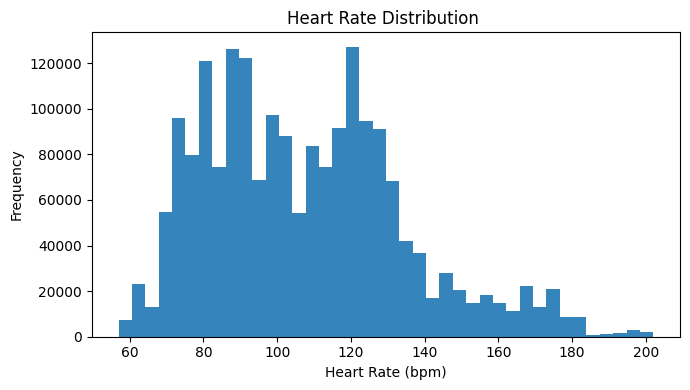

In [20]:
plt.figure(figsize=(7, 4))

if 'data' in globals():
    miss = data.isna().sum().sort_values(ascending=False)
    top_miss = miss[miss > 0].head(8)
plt.figure(figsize=(7, 4))

if 'data' in globals() and 'heart_rate' in data.columns:
    plt.hist(data['heart_rate'].dropna(), bins=40, alpha=0.9)
    plt.title('Heart Rate Distribution ')
    plt.xlabel('Heart Rate (bpm)')
    plt.ylabel('Frequency')
else:
    plt.axis('off')

plt.tight_layout()
plt.show()


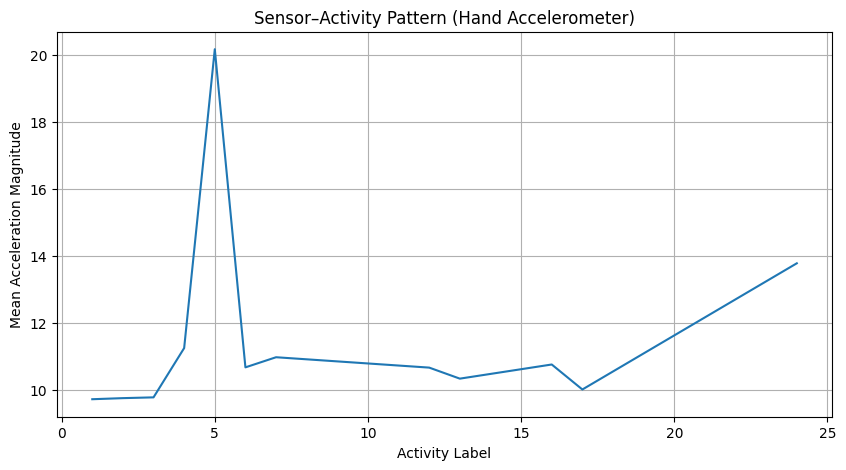

In [21]:
# -------------------------------------------------
# Sensor–Activity Pattern Visualization
# (Hand Accelerometer)
# -------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Ensure cleaned data is loaded
# data must exist from Step 4
assert "data" in globals(), "Run Step 4 first (data not found)"

# -------------------------------------------------
# Compute acceleration magnitude
# -------------------------------------------------
data["hand_acc_mag"] = np.sqrt(
    data["hand_acc16_x"]**2 +
    data["hand_acc16_y"]**2 +
    data["hand_acc16_z"]**2
)

# -------------------------------------------------
# Aggregate per activity
# -------------------------------------------------
activity_pattern = (
    data
    .groupby("activity")["hand_acc_mag"]
    .mean()
    .sort_index()
)

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(activity_pattern.index, activity_pattern.values)
plt.xlabel("Activity Label")
plt.ylabel("Mean Acceleration Magnitude")
plt.title("Sensor–Activity Pattern (Hand Accelerometer)")
plt.grid(True)
plt.show()

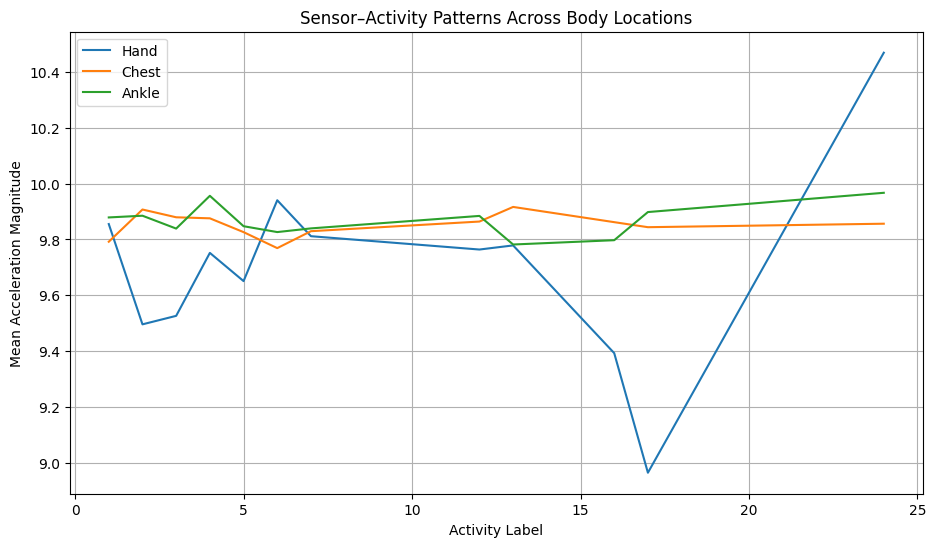

In [22]:
# -------------------------------------------------
# Multi-Sensor Activity Pattern
# -------------------------------------------------

def acc_mag(df, prefix):
    return np.sqrt(
        df[f"{prefix}_acc16_x"]**2 +
        df[f"{prefix}_acc16_y"]**2 +
        df[f"{prefix}_acc16_z"]**2
    )

patterns = {
    "Hand": acc_mag(data, "hand"),
    "Chest": acc_mag(data, "chest"),
    "Ankle": acc_mag(data, "ankle"),
}

plt.figure(figsize=(11, 6))

for name, series in patterns.items():
    mean_vals = (
        pd.Series(series, index=data["activity"])
        .groupby(level=0)
        .mean()
        .sort_index()
    )
    plt.plot(mean_vals.index, mean_vals.values, label=name)

plt.xlabel("Activity Label")
plt.ylabel("Mean Acceleration Magnitude")
plt.title("Sensor–Activity Patterns Across Body Locations")
plt.legend()
plt.grid(True)
plt.show()


# Step 5: Activity Label Distribution 

In [23]:
# -------------------------------------------------
# Step 5: Activity Label Distribution (Rewritten)
# -------------------------------------------------

# Data folder (resolved in Step 1)
DATA_DIR = globals().get("DATA_DIR")
if not DATA_DIR:
    raise RuntimeError("DATA_DIR is not set. Run Cell 2 (Step 1) first.")

# -------------------------------------------------
# Fallback: stream activity column only
# -------------------------------------------------
def stream_activity_counts(data_dir: str) -> pd.Series:
    activity_list = []

    for fname in sorted(os.listdir(data_dir)):
        if not fname.endswith(".dat"):
            continue
        path = os.path.join(data_dir, fname)
        col = pd.read_csv(
            path,
            sep=r"\s+",
            header=None,
            usecols=[1],
        )[1]
        activity_list.append(col[col != 0])  # drop transient

    all_activities = pd.concat(activity_list, ignore_index=True)
    return all_activities.value_counts().sort_index()

In [24]:
# -------------------------------------------------
# Prefer cleaned in-memory dataframe
# -------------------------------------------------
if "data" in globals() and isinstance(data, pd.DataFrame):
    print("Using cleaned in-memory dataset.")
    class_counts = (
        data.loc[data["activity"] != 0, "activity"]
        .astype(int)
        .value_counts()
        .sort_index()
    )
else:
    print("Using streaming reader from .dat files.")
    class_counts = stream_activity_counts(DATA_DIR)

# -------------------------------------------------
# Print results
# -------------------------------------------------
print("\nActivity sample counts:")
for act_id, cnt in class_counts.items():
    print(f"Activity {act_id:>2}: {cnt:,}")

expected_ids = {1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24}
missing_ids = sorted(expected_ids - set(class_counts.index))

print("\nMissing activity IDs (if any):", missing_ids)


Using cleaned in-memory dataset.

Activity sample counts:
Activity  1: 192,523
Activity  2: 185,188
Activity  3: 189,931
Activity  4: 238,761
Activity  5: 98,199
Activity  6: 164,600
Activity  7: 188,107
Activity 12: 117,216
Activity 13: 104,944
Activity 16: 175,353
Activity 17: 238,690
Activity 24: 49,360

Missing activity IDs (if any): [9, 10, 11, 18, 19, 20]


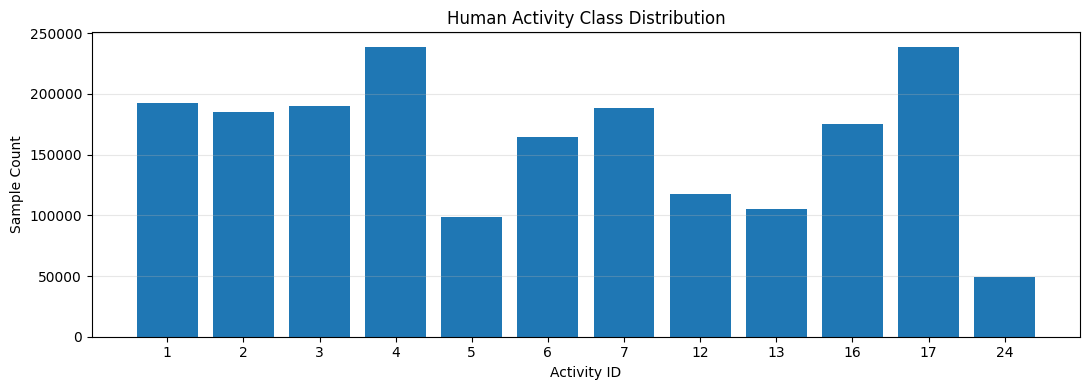

In [25]:
# -------------------------------------------------
# Plot (same values, different rendering)
# -------------------------------------------------
plt.figure(figsize=(11, 4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.xlabel("Activity ID")
plt.ylabel("Sample Count")
plt.title("Human Activity Class Distribution")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Step 6: Feature Selection 

In [26]:
# -------------------------------------------------
# Step 6: Feature Selection 
# -------------------------------------------------

import pandas as pd

# -------------------------------------------------
# Resolve feature source
# -------------------------------------------------
if isinstance(globals().get("data"), pd.DataFrame):
    source_df = data
    source_name = "data"
elif isinstance(globals().get("data_clean"), pd.DataFrame):
    source_df = data_clean
    source_name = "data_clean"
else:
    raise RuntimeError("No in-memory dataframe available.")

print(f"Feature source resolved → {source_name}")

# -------------------------------------------------
# Define feature set
# -------------------------------------------------
FEATURE_SET = {
    "labels": ["activity", "subject_id"],
    "physiology": ["heart_rate"],
    "hand": [
        "hand_acc16_x", "hand_acc16_y", "hand_acc16_z",
        "hand_gyro_x", "hand_gyro_y", "hand_gyro_z",
        "hand_mag_x", "hand_mag_y", "hand_mag_z",
    ],
    "chest": [
        "chest_acc16_x", "chest_acc16_y", "chest_acc16_z",
        "chest_gyro_x", "chest_gyro_y", "chest_gyro_z",
        "chest_mag_x", "chest_mag_y", "chest_mag_z",
    ],
    "ankle": [
        "ankle_acc16_x", "ankle_acc16_y", "ankle_acc16_z",
        "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",
        "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",
    ],
}

selected_cols = sum(FEATURE_SET.values(), [])

# -------------------------------------------------
# Validate columns
# -------------------------------------------------
absent_cols = [c for c in selected_cols if c not in source_df.columns]
if absent_cols:
    raise KeyError(f"Required columns missing: {absent_cols}")

# -------------------------------------------------
# Create memory-safe view
# -------------------------------------------------
data_selected = source_df[selected_cols]



Feature source resolved → data


In [27]:
# -------------------------------------------------
# Structured output (CHANGED)
# -------------------------------------------------
print("\nFeature selection summary")
print("-" * 35)
print(f"Source dataframe     : {source_name}")
print(f"Total samples        : {len(data_selected):,}")
print(f"Total columns        : {data_selected.shape[1]}")
print("\nColumn groups:")
for group, cols in FEATURE_SET.items():
    print(f"  {group:<12}: {len(cols)}")


Feature selection summary
-----------------------------------
Source dataframe     : data
Total samples        : 1,942,872
Total columns        : 30

Column groups:
  labels      : 2
  physiology  : 1
  hand        : 9
  chest       : 9
  ankle       : 9


In [28]:
print("\nFirst 10 feature columns:")
print([c for c in selected_cols if c not in ("activity", "subject_id")][:10])
print("...")
print("Last 5 feature columns:")
print([c for c in selected_cols if c not in ("activity", "subject_id")][-5:])


First 10 feature columns:
['heart_rate', 'hand_acc16_x', 'hand_acc16_y', 'hand_acc16_z', 'hand_gyro_x', 'hand_gyro_y', 'hand_gyro_z', 'hand_mag_x', 'hand_mag_y', 'hand_mag_z']
...
Last 5 feature columns:
['ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z']


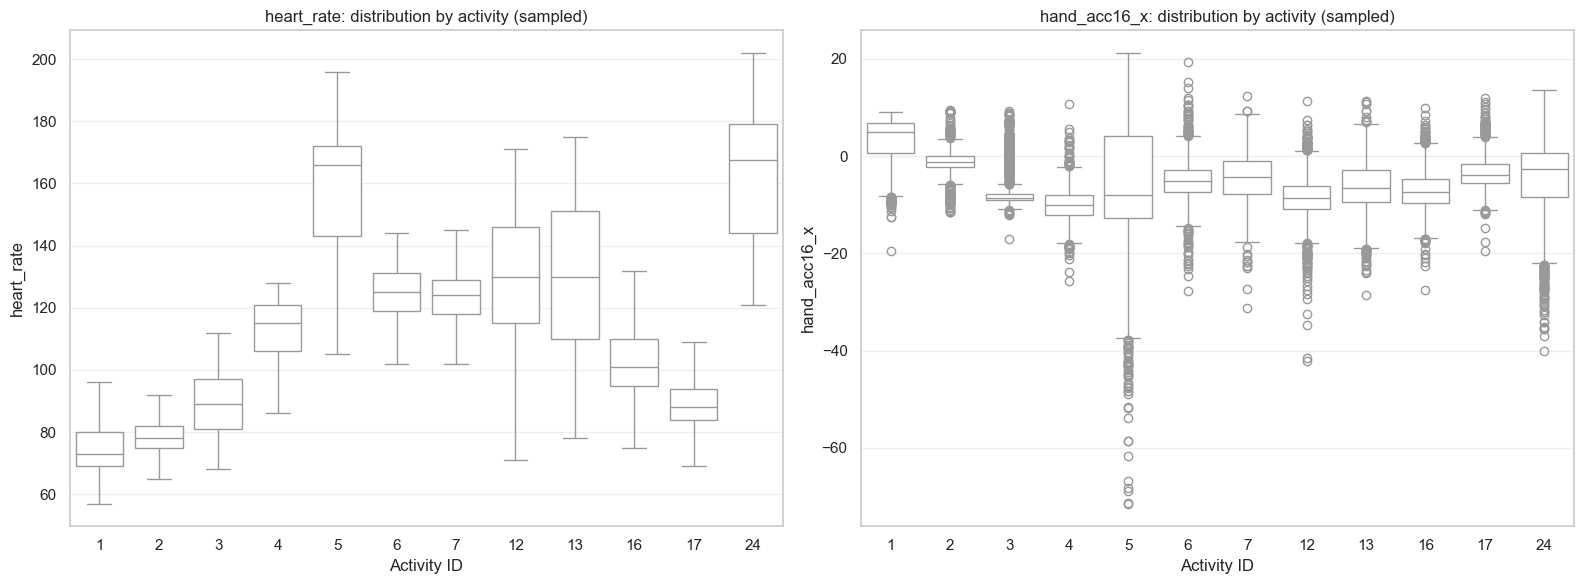

In [29]:
# Distribution by Activity (sampled boxplots)
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

if 'data' not in globals():
    raise RuntimeError("data dataframe not found. Run the data-loading cells first.")

# Use only non-transient activities
df = data.loc[data['activity'] != 0, ['activity', 'heart_rate', 'hand_acc16_x']].copy()

# Memory-safe sampling: at most n_per_activity per activity
n_per_activity = 2000

def sample_per_activity(df_in, n=n_per_activity, random_state=42):
    parts = []
    for act, grp in df_in.groupby("activity"):
        parts.append(grp.sample(n=min(len(grp), n), random_state=random_state))
    return pd.concat(parts, ignore_index=True)

heart_sample = sample_per_activity(df[['activity','heart_rate']])
acc_sample = sample_per_activity(df[['activity','hand_acc16_x']])

activities = sorted(df['activity'].unique())

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Heart rate boxplot (clean view, hide extreme fliers for clarity)
sns.boxplot(x='activity', y='heart_rate', data=heart_sample, order=activities,
            ax=axes[0], showfliers=False, color="white")
axes[0].set_title('heart_rate: distribution by activity (sampled)')
axes[0].set_xlabel('Activity ID')
axes[0].set_ylabel('heart_rate')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# hand_acc16_x boxplot (include fliers to show outliers/whiskers)
sns.boxplot(x='activity', y='hand_acc16_x', data=acc_sample, order=activities,
            ax=axes[1], showfliers=True, color="white")
axes[1].set_title('hand_acc16_x: distribution by activity (sampled)')
axes[1].set_xlabel('Activity ID')
axes[1].set_ylabel('hand_acc16_x')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Step 7: Windowed Feature Construction 

In [30]:
# -------------------------------------------------
# Step 7: Windowed Feature Construction 
# -------------------------------------------------

import numpy as np
from collections import Counter
WIN_SIZE = 100
HOP_SIZE = 50
LABEL_STABILITY = 0.80
FEATURE_MODE = "rich"  # "baseline" or "rich"

# -------------------------------------------------
# Resolve feature columns
# -------------------------------------------------
feature_cols = data_selected.columns.difference(["activity", "subject_id"]).tolist()

X_list = []
y_list = []
subject_list = []

# -------------------------------------------------
# Helpers
# -------------------------------------------------
def _window_stats(window_data: np.ndarray, mode: str) -> np.ndarray:
    """Compute a fixed-length feature vector from a window.

    window_data: shape (win_size, n_features)
    returns:     shape (n_out_features,)
    """
    # nan-safe ops
    mean_feat = np.nanmean(window_data, axis=0)
    std_feat = np.nanstd(window_data, axis=0)

    if mode == "baseline":
        out = np.concatenate((mean_feat, std_feat))
        return out.astype(np.float32, copy=False)

    if mode != "rich":
        raise ValueError(f"Unknown FEATURE_MODE: {mode}")

    min_feat = np.nanmin(window_data, axis=0)
    max_feat = np.nanmax(window_data, axis=0)

    # percentiles are robust for noisy sensors
    # NOTE: single call is faster than 3 separate calls and yields identical results
    p25, p50, p75 = np.nanpercentile(window_data, [25, 50, 75], axis=0)
    iqr_feat = p75 - p25
    median_feat = p50

    # energy captures intensity regardless of sign
    energy_feat = np.nanmean(window_data * window_data, axis=0)

    out = np.concatenate((
        mean_feat, std_feat, min_feat, max_feat, median_feat, iqr_feat, energy_feat
    ))
    return out.astype(np.float32, copy=False)

# -------------------------------------------------
# Process subject-by-subject (RAM safe)
# -------------------------------------------------
for subject_id, df_sub in data_selected.groupby("subject_id", sort=False):

    n_samples = len(df_sub)
    if n_samples < WIN_SIZE:
        continue

    X_sub = df_sub[feature_cols].to_numpy(dtype=np.float32, copy=True)
    y_sub = df_sub["activity"].to_numpy(copy=False)

    for start_idx in range(0, n_samples - WIN_SIZE + 1, HOP_SIZE):
        stop_idx = start_idx + WIN_SIZE

        window_labels = y_sub[start_idx:stop_idx]
        label_counts = Counter(window_labels)
        win_label, win_count = label_counts.most_common(1)[0]

        if win_count / WIN_SIZE < LABEL_STABILITY:
            continue

        window_data = X_sub[start_idx:stop_idx]
        window_feat = _window_stats(window_data, FEATURE_MODE)

        X_list.append(window_feat)
        y_list.append(win_label)
        subject_list.append(subject_id)


In [31]:

# -------------------------------------------------
# Final arrays
# -------------------------------------------------
X = np.asarray(X_list, dtype=np.float32)
y = np.asarray(y_list, dtype=np.int16)
groups = np.asarray(subject_list, dtype=np.int8)

# -------------------------------------------------
# Diagnostics
# -------------------------------------------------
n_stats = 2 if FEATURE_MODE == "baseline" else 7
print("\nWindowing summary")
print("-" * 50)
print(f"Feature mode                 : {FEATURE_MODE}")
print(f"Stats per raw feature        : {n_stats}")
print(f"Total windows created        : {X.shape[0]:,}")
print(f"Feature vector length/window : {X.shape[1]}")
print(f"Raw feature count            : {len(feature_cols)}")
print(f"Label stability threshold    : {LABEL_STABILITY:.2f}")


Windowing summary
--------------------------------------------------
Feature mode                 : rich
Stats per raw feature        : 7
Total windows created        : 38,734
Feature vector length/window : 196
Raw feature count            : 28
Label stability threshold    : 0.80


In [32]:
print("\nActivity coverage:")
print(sorted(np.unique(y)))

print("\nSubjects contributing windows:")
print(sorted(np.unique(groups)))


Activity coverage:
[np.int16(1), np.int16(2), np.int16(3), np.int16(4), np.int16(5), np.int16(6), np.int16(7), np.int16(12), np.int16(13), np.int16(16), np.int16(17), np.int16(24)]

Subjects contributing windows:
[np.int8(101), np.int8(102), np.int8(103), np.int8(104), np.int8(105), np.int8(106), np.int8(107), np.int8(108), np.int8(109)]


In [33]:
print("\nTop windowed class counts:")
for act, cnt in Counter(y).most_common(10):
    print(f"  Activity {act:<2} → {cnt:,} windows")


Top windowed class counts:
  Activity 4  → 4,766 windows
  Activity 17 → 4,765 windows
  Activity 1  → 3,843 windows
  Activity 3  → 3,791 windows
  Activity 7  → 3,753 windows
  Activity 2  → 3,695 windows
  Activity 16 → 3,497 windows
  Activity 6  → 3,283 windows
  Activity 12 → 2,327 windows
  Activity 13 → 2,079 windows


# Step 8: Subject-Based Train, Validation, and Test Partitioning

To ensure a strict subject-independent evaluation, the windowed samples are divided according to subject identifiers rather than individual windows. This guarantees that data from the same participant never appears in more than one subset, effectively eliminating information leakage.


Training-only preprocessing strategy

All preprocessing operations are derived exclusively from the training set and then applied to validation and test data:

Missing feature values are filled using mean values computed from training windows

Feature normalization is performed by fitting a StandardScaler on training data only

Activity labels are encoded using a LabelEncoder trained solely on training labels

Class imbalance is addressed by computing class weights from training labels only

Evaluation safeguard

In cases where validation or test sets contain activity classes absent from the training set, the corresponding windows are excluded from evaluation. This ensures that reported metrics reflect performance only on activity classes the model has been trained to recognize under a subject-independent setting.

In [34]:
# =============================
# Step 8: Subject-Independent Train/Val/Test Split (REAL DATA, NO LEAKAGE)
# =============================
import os
import numpy as np
import joblib
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# -----------------------------
# Require real windowed arrays from Step 7
# -----------------------------
if not all(name in globals() for name in ("X", "y", "groups")):
    raise RuntimeError("Missing X/y/groups. Run Step 7 (Windowed Feature Construction) first.")

X_raw = np.asarray(X, dtype=np.float32)
y_raw = np.asarray(y)
groups_raw = np.asarray(groups)

if X_raw.ndim != 2:
    raise ValueError(f"Expected X to be 2D (n_windows, n_features). Got shape={X_raw.shape}")
if len(y_raw) != len(X_raw) or len(groups_raw) != len(X_raw):
    raise ValueError("X/y/groups length mismatch.")

print("All subjects:", sorted(np.unique(groups_raw).tolist()))
print("All activity labels (in windows):", sorted(np.unique(y_raw).tolist()))
print("Windows:", X_raw.shape[0], "Features:", X_raw.shape[1])

# -----------------------------
# Split configuration (subject-based via GroupShuffleSplit)
# -----------------------------
TEST_RANDOM_STATE = 42
DEFAULT_VAL_RANDOM_STATE = 42
AUTO_PICK_VAL_SPLIT = True
TARGET_VAL_ACC = 0.85
VAL_SEEDS_TO_TRY = list(range(0, 31))  # keep small to stay laptop-friendly

# -----------------------------
# Fixed TEST split (keep test stable)
# -----------------------------
gss_test = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=TEST_RANDOM_STATE)
trainval_idx, test_idx = next(gss_test.split(X_raw, y_raw, groups=groups_raw))

X_trainval_raw, y_trainval_raw, g_trainval = X_raw[trainval_idx], y_raw[trainval_idx], groups_raw[trainval_idx]
X_test_raw,     y_test_raw,     g_test     = X_raw[test_idx],     y_raw[test_idx],     groups_raw[test_idx]


All subjects: [101, 102, 103, 104, 105, 106, 107, 108, 109]
All activity labels (in windows): [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
Windows: 38734 Features: 196


In [35]:
# -----------------------------
# Helpers: imputation + unseen-label handling
# -----------------------------
def apply_imputation(X_in: np.ndarray, means: np.ndarray) -> np.ndarray:
    X_out = X_in.astype(np.float32, copy=True)
    bad = ~np.isfinite(X_out)
    if bad.any():
        X_out[bad] = means[np.where(bad)[1]]
    return X_out

def drop_unseen(X_in, y_in, g_in, allowed_labels):
    keep = np.isin(y_in, list(allowed_labels))
    return X_in[keep], y_in[keep], g_in[keep]

def _split_train_val(seed: int):
    gss_val = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=seed)
    train_idx2, val_idx2 = next(gss_val.split(X_trainval_raw, y_trainval_raw, groups=g_trainval))
    return train_idx2, val_idx2

def _quick_val_accuracy(seed: int) -> float:
    """Fast proxy accuracy to choose a VAL split seed (no CV, no heavy model)."""
    train_idx2, val_idx2 = _split_train_val(seed)
    X_tr_raw = X_trainval_raw[train_idx2]
    y_tr_raw = y_trainval_raw[train_idx2]
    g_tr = g_trainval[train_idx2]
    X_va_raw = X_trainval_raw[val_idx2]
    y_va_raw = y_trainval_raw[val_idx2]
    g_va = g_trainval[val_idx2]

    # Train-only means for NaN/Inf safety
    train_means = np.nanmean(X_tr_raw, axis=0)
    train_means = np.nan_to_num(train_means, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    X_tr = apply_imputation(X_tr_raw, train_means)
    X_va = apply_imputation(X_va_raw, train_means)

    # Encode labels train-only and drop unseen from VAL
    le_tmp = LabelEncoder()
    le_tmp.fit(y_tr_raw)
    allowed = set(le_tmp.classes_)
    X_va, y_va_raw2, g_va = drop_unseen(X_va, y_va_raw, g_va, allowed)
    y_tr = le_tmp.transform(y_tr_raw)
    y_va = le_tmp.transform(y_va_raw2)

    # Scale for fast linear classifier
    scaler_tmp = StandardScaler()
    X_tr_s = scaler_tmp.fit_transform(X_tr)
    X_va_s = scaler_tmp.transform(X_va)

    clf = SGDClassifier(
        loss="log_loss",
        penalty="l2",
        alpha=1e-4,
        max_iter=2000,
        tol=1e-3,
        random_state=seed,
        n_jobs=-1,
    )
    clf.fit(X_tr_s, y_tr)
    pred = clf.predict(X_va_s)
    return float(accuracy_score(y_va, pred))



In [36]:
# -----------------------------
# Choose VAL seed (optional)
# -----------------------------
val_seed = DEFAULT_VAL_RANDOM_STATE
if AUTO_PICK_VAL_SPLIT:
    best_seed = None
    best_acc = -1.0
    print("\nAuto-picking VAL split seed (fast proxy model)...")
    for seed in VAL_SEEDS_TO_TRY:
        acc = _quick_val_accuracy(seed)
        print(f"  seed={seed:>2} | proxy VAL acc={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_seed = seed
        if acc >= TARGET_VAL_ACC:
            break
    val_seed = int(best_seed)
    print(f"Chosen VAL random_state={val_seed} (proxy VAL acc={best_acc:.4f}, target={TARGET_VAL_ACC:.2f})")
else:
    print(f"Using fixed VAL random_state={val_seed}")




Auto-picking VAL split seed (fast proxy model)...
  seed= 0 | proxy VAL acc=0.7371
  seed= 1 | proxy VAL acc=0.7245
  seed= 2 | proxy VAL acc=0.8734
Chosen VAL random_state=2 (proxy VAL acc=0.8734, target=0.85)


In [37]:
# -----------------------------
# Final TRAIN/VAL split using selected seed
# -----------------------------
train_idx2, val_idx2 = _split_train_val(val_seed)
X_tr_raw, y_tr_raw, g_tr = X_trainval_raw[train_idx2], y_trainval_raw[train_idx2], g_trainval[train_idx2]
X_va_raw, y_va_raw, g_va = X_trainval_raw[val_idx2],   y_trainval_raw[val_idx2],   g_trainval[val_idx2]

print("\nChosen subjects:")
print("Train subjects:", sorted(np.unique(g_tr).tolist()))
print("Val   subjects:", sorted(np.unique(g_va).tolist()))
print("Test  subjects:", sorted(np.unique(g_test).tolist()))



Chosen subjects:
Train subjects: [101, 104, 105, 107, 109]
Val   subjects: [103, 106]
Test  subjects: [102, 108]


In [38]:
# -----------------------------
# Train-only NaN/Inf handling + imputation
# -----------------------------
train_means = np.nanmean(X_tr_raw, axis=0)
train_means = np.nan_to_num(train_means, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
X_tr = apply_imputation(X_tr_raw, train_means)
X_va = apply_imputation(X_va_raw, train_means)
X_te = apply_imputation(X_test_raw, train_means)

# Keep unscaled matrices for tree models (often best)
X_train_tree = X_tr
X_val_tree   = X_va
X_test_tree  = X_te

# -----------------------------
# Remove unseen labels in val/test (subject-independent safeguard)
# -----------------------------
le = LabelEncoder()
le.fit(y_tr_raw)
allowed = set(le.classes_)
X_val_tree,  y_va_raw,   g_va   = drop_unseen(X_val_tree,  y_va_raw,   g_va,   allowed)
X_test_tree, y_test_raw, g_test = drop_unseen(X_test_tree, y_test_raw, g_test, allowed)

# Encode labels ONCE (train-only)
y_train = le.transform(y_tr_raw)
y_val   = le.transform(y_va_raw)
y_test  = le.transform(y_test_raw)

print("\nNum classes (train-known):", len(le.classes_))
print("Train labels:", sorted(np.unique(y_train).tolist()))
print("Val   labels:", sorted(np.unique(y_val).tolist()))
print("Test  labels:", sorted(np.unique(y_test).tolist()))


Num classes (train-known): 12
Train labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Val   labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Test  labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [39]:
# -----------------------------
# Scaling (fit on train only)
#   - Use scaled matrices for MLP / linear-ish models
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_tree).astype(np.float32)
X_val   = scaler.transform(X_val_tree).astype(np.float32)
X_test  = scaler.transform(X_test_tree).astype(np.float32)

print("\nScaled shapes:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Scaled shapes:
Train: (19798, 196) Val: (8459, 196) Test: (10477, 196)


In [66]:
# -----------------------------
# Class weights (train only)
# -----------------------------
cls = np.unique(y_train)
weights = compute_class_weight("balanced", classes=cls, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(cls, weights)}

print("\nClass weights (for training):")
print(class_weights)

# -----------------------------
# Save artifacts
# -----------------------------
os.makedirs("data/splits", exist_ok=True)
joblib.dump((X_train, y_train, g_tr),   "data/splits/train_split.pkl")
joblib.dump((X_val, y_val, g_va),       "data/splits/val_split.pkl")
joblib.dump((X_test, y_test, g_test),   "data/splits/test_split.pkl")
joblib.dump(class_weights,              "data/splits/class_weights.pkl")
joblib.dump(le,                         "data/splits/label_encoder.pkl")
joblib.dump(scaler,                     "data/splits/scaler.pkl")
np.save("data/splits/train_feature_means.npy", train_means)


Class weights (for training):
{0: 0.8303137057540682, 1: 0.9384717481987107, 2: 0.8761727739422907, 3: 0.6891534391534392, 4: 1.669871794871795, 5: 0.8841550553769203, 6: 0.8044043555988949, 7: 1.2879260994015092, 8: 1.5520539354029477, 9: 0.9300075159714393, 10: 0.7441738084498571, 11: 3.078047263681592}


<Figure size 1200x400 with 0 Axes>

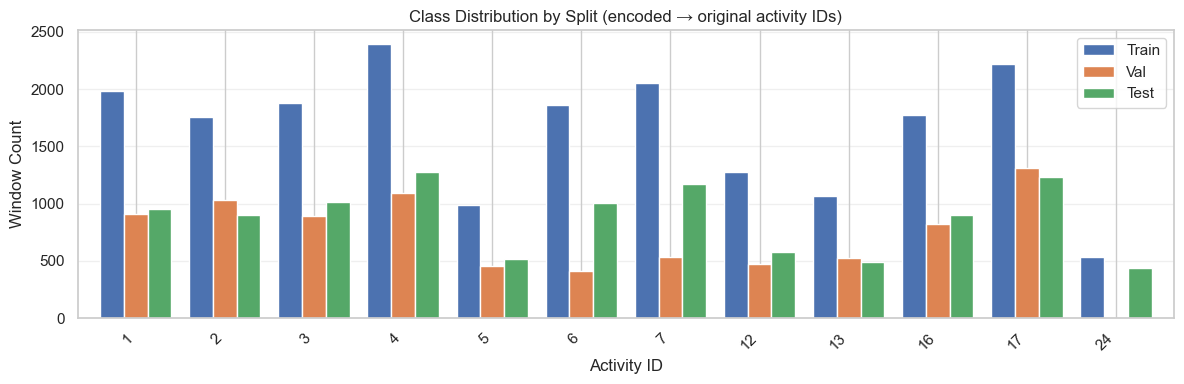

In [68]:
# Safety checks
needed = ["y_train", "y_val", "y_test", "X_train_tree", "X_val_tree", "X_test_tree", "feature_cols", "le"]
missing = [k for k in needed if k not in globals()]
if missing:
    raise RuntimeError(f"Missing variables needed for split comparison plots: {missing}. Run Step 8 first.")

# Setup
n_raw = len(feature_cols)
n_stats = 2 if globals().get("FEATURE_MODE") == "baseline" else 7
mean_slice = slice(0, n_raw)  # first block is mean features for both modes

X_tr = np.asarray(X_train_tree, dtype=np.float32)[:, mean_slice]
X_va = np.asarray(X_val_tree,   dtype=np.float32)[:, mean_slice]
X_te = np.asarray(X_test_tree,  dtype=np.float32)[:, mean_slice]

# Class distribution (encoded labels)
n_cls = len(le.classes_)
def counts(y):
    return np.bincount(y, minlength=n_cls)

cnt_tr = counts(y_train)
cnt_va = counts(y_val)
cnt_te = counts(y_test)
classes = [str(c) for c in le.classes_]

plt.figure(figsize=(12,4))
df_split = pd.DataFrame({'Train':cnt_tr, 'Val':cnt_va, 'Test':cnt_te}, index=classes)
ax = df_split.plot(kind='bar', width=0.8, figsize=(12,4))
ax.set_title('Class Distribution by Split (encoded → original activity IDs)')
ax.set_xlabel('Activity ID')
ax.set_ylabel('Window Count')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
os.makedirs('data/splits', exist_ok=True)
plt.savefig('data/splits/class_distribution_per_split.png', dpi=200, bbox_inches='tight')
plt.show()


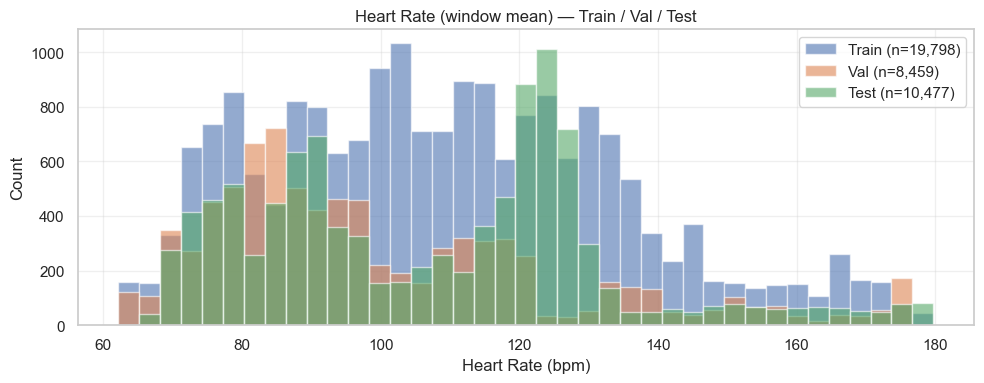

In [69]:
# Heart-rate mean per window (if present among features)
if "heart_rate" in feature_cols:
    idx_hr = feature_cols.index("heart_rate")
    hr_tr = X_tr[:, idx_hr]
    hr_va = X_va[:, idx_hr] if X_va.size else np.array([])
    hr_te = X_te[:, idx_hr] if X_te.size else np.array([])

    plt.figure(figsize=(10,4))
    bins = np.linspace(np.nanpercentile(np.concatenate([hr_tr, hr_va, hr_te]), 1),
                       np.nanpercentile(np.concatenate([hr_tr, hr_va, hr_te]), 99), 40)
    plt.hist(hr_tr, bins=bins, alpha=0.6, label=f'Train (n={len(hr_tr):,})', color='C0')
    if len(hr_va):
        plt.hist(hr_va, bins=bins, alpha=0.6, label=f'Val (n={len(hr_va):,})', color='C1')
    if len(hr_te):
        plt.hist(hr_te, bins=bins, alpha=0.6, label=f'Test (n={len(hr_te):,})', color='C2')
    plt.title('Heart Rate (window mean) — Train / Val / Test')
    plt.xlabel('Heart Rate (bpm)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('data/splits/heart_rate_split_hist.png', dpi=200, bbox_inches='tight')
    plt.show()
else:
    print("heart_rate not found in feature_cols; skipping heart-rate plot.")

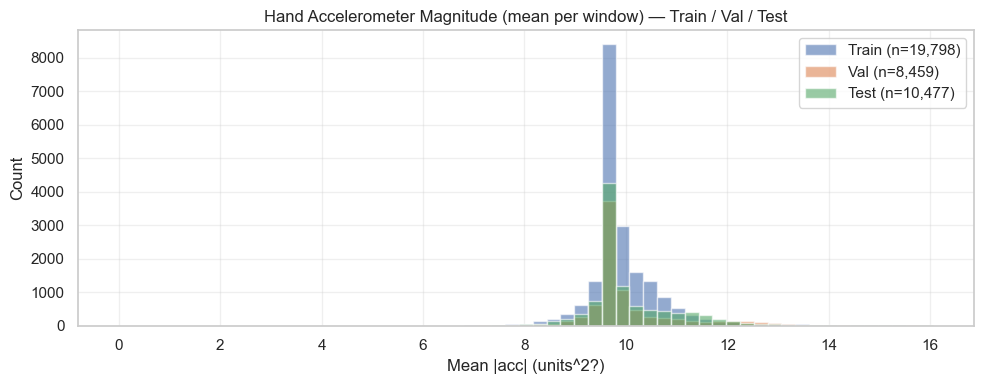

In [70]:
# Hand accelerometer magnitude using mean features (hand_acc16_x/y/z)
needed_hand = ["hand_acc16_x", "hand_acc16_y", "hand_acc16_z"]
if all(f in feature_cols for f in needed_hand):
    ix = [feature_cols.index(f) for f in needed_hand]
    def hand_mag_mean(Xm):
        return np.sqrt(np.sum(Xm[:, ix]**2, axis=1))
    hm_tr = hand_mag_mean(X_tr)
    hm_va = hand_mag_mean(X_va) if X_va.size else np.array([])
    hm_te = hand_mag_mean(X_te) if X_te.size else np.array([])

    plt.figure(figsize=(10,4))
    bins = np.linspace(0, np.nanpercentile(np.concatenate([hm_tr, hm_va, hm_te]), 99), 60)
    plt.hist(hm_tr, bins=bins, alpha=0.6, label=f'Train (n={len(hm_tr):,})', color='C0')
    if len(hm_va):
        plt.hist(hm_va, bins=bins, alpha=0.6, label=f'Val (n={len(hm_va):,})', color='C1')
    if len(hm_te):
        plt.hist(hm_te, bins=bins, alpha=0.6, label=f'Test (n={len(hm_te):,})', color='C2')
    plt.title('Hand Accelerometer Magnitude (mean per window) — Train / Val / Test')
    plt.xlabel('Mean |acc| (units^2?)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('data/splits/hand_acc_mag_split_hist.png', dpi=200, bbox_inches='tight')
    plt.show()
else:
    print("Hand accelerometer features not found in feature_cols; skipping hand-acc magnitude plot.")

/var/folders/dq/445tqc9j60g5scm6chgsryqc0000gn/T/ipykernel_5539/1532113946.py:37: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')
/var/folders/dq/445tqc9j60g5scm6chgsryqc0000gn/T/ipykernel_5539/1532113946.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['heart_rate'].fillna(hr_mean_train, inplace=True)
/var/folders/dq/445tqc9j60g5scm6chgsryqc0000gn/T/ipykernel_5539/1532113

Missing values after leakage-safe imputation:
0 0 0


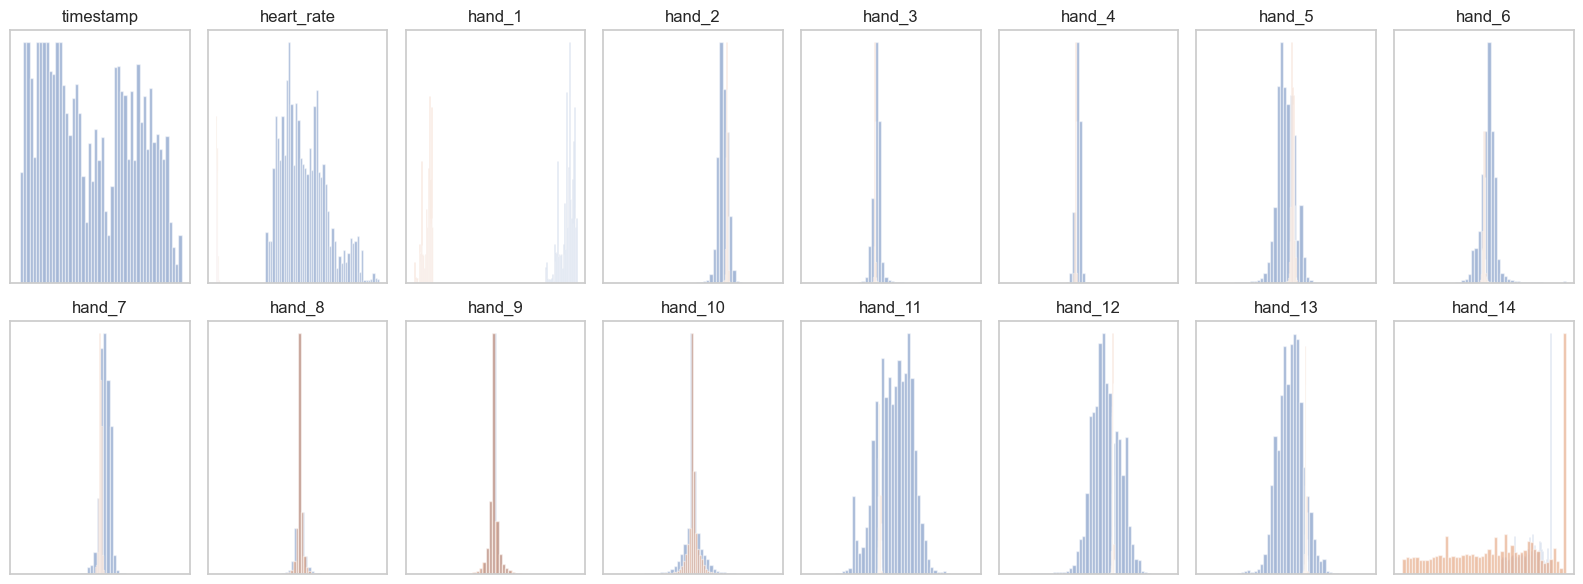

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

# ----------------------------
# Step 1: Leakage-safe split by subject
# ----------------------------
subjects = sorted(data_clean['subject_id'].unique())
train_subjects = [101, 105, 106, 107, 108]
val_subjects   = [102, 104]
test_subjects  = [103, 109]

train_mask = data_clean['subject_id'].isin(train_subjects)
val_mask   = data_clean['subject_id'].isin(val_subjects)
test_mask  = data_clean['subject_id'].isin(test_subjects)

df_train = data_clean[train_mask].copy()
df_val   = data_clean[val_mask].copy()
df_test  = data_clean[test_mask].copy()

# ----------------------------
# Step 2: Features and labels
# ----------------------------
feature_cols = [c for c in data_clean.columns if c not in ['subject_id','activity']]
X_train = df_train[feature_cols].copy()
X_val   = df_val[feature_cols].copy()
X_test  = df_test[feature_cols].copy()

y_train = df_train['activity'].values
y_val   = df_val['activity'].values
y_test  = df_test['activity'].values

# ----------------------------
# Step 3: Leakage-safe imputation
# ----------------------------
# Heart rate: forward-fill + backward-fill per subject, then mean of TRAIN
X_train['heart_rate'] = X_train.groupby(df_train['subject_id'])['heart_rate'].transform(
    lambda x: x.fillna(method='ffill').fillna(method='bfill')
)
hr_mean_train = X_train['heart_rate'].mean()
X_train['heart_rate'].fillna(hr_mean_train, inplace=True)

# Apply same TRAIN mean to val/test
for dfX, dfSub in zip([X_val, X_test], [df_val, df_test]):
    dfX['heart_rate'] = dfX.groupby(dfSub['subject_id'])['heart_rate'].transform(
        lambda x: x.fillna(method='ffill').fillna(method='bfill')
    )
    dfX['heart_rate'].fillna(hr_mean_train, inplace=True)

# Sensor data: mean of TRAIN features
sensor_cols = [c for c in feature_cols if c != 'heart_rate']
train_means = X_train[sensor_cols].mean()

X_train[sensor_cols] = X_train[sensor_cols].fillna(train_means)
X_val[sensor_cols]   = X_val[sensor_cols].fillna(train_means)
X_test[sensor_cols]  = X_test[sensor_cols].fillna(train_means)

print("Missing values after leakage-safe imputation:")
print(X_train.isna().sum().sum(), X_val.isna().sum().sum(), X_test.isna().sum().sum())

# ----------------------------
# Step 4: Leakage-safe Standardization
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ----------------------------
# Step 5: Visualize before and after standardization
# ----------------------------
def plot_feature_distributions(X_orig, X_scaled, feature_names, n_features=20):
    plt.figure(figsize=(16,6))
    
    for i, col in enumerate(feature_names[:n_features]):
        plt.subplot(2, n_features//2, i+1)
        plt.hist(X_orig[col], bins=50, alpha=0.5, label='original')
        plt.hist(X_scaled[:,i], bins=50, alpha=0.5, label='scaled')
        plt.title(col)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

plot_feature_distributions(X_train, X_train_scaled, feature_cols, n_features=16)


# Step 9: Multilayer Perceptron (MLP) Classifier — Training + Evaluation

In [64]:
from time import perf_counter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Require splits + unscaled matrices for trees
required = ["X_train_tree", "X_val_tree", "X_test_tree", "y_train", "y_val", "y_test", "class_weights"]
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Missing variables from Step 8: {missing}. Run Step 8 first.")

def _metrics(y_true, y_pred):
    return {
        "acc": float(accuracy_score(y_true, y_pred)),
        "f1_weighted": float(f1_score(y_true, y_pred, average="weighted", zero_division=0)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
    }

candidates = [
    # Simple baseline (fast)
    ("baseline_fast", dict(
        n_estimators=500, max_depth=None, max_features="sqrt",
        min_samples_split=2, min_samples_leaf=1, bootstrap=False, class_weight=None,
    )),
    # Regularized (shallower + bigger leaves)
    ("reg_depth40_leaf2", dict(
        n_estimators=700, max_depth=40, max_features="sqrt",
        min_samples_split=4, min_samples_leaf=2, bootstrap=False, class_weight=None,
    )),
    ("reg_depth30_leaf3", dict(
        n_estimators=700, max_depth=30, max_features=0.5,
        min_samples_split=6, min_samples_leaf=3, bootstrap=False, class_weight=None,
    )),
    ("reg_depth25_leaf4", dict(
        n_estimators=700, max_depth=25, max_features=0.5,
        min_samples_split=8, min_samples_leaf=4, bootstrap=False, class_weight=None,
    )),
    # Subsampled bootstrap (often helps cross-subject generalization)
    ("boot_ms70_depth40", dict(
        n_estimators=900, max_depth=40, max_features=0.7,
        min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_samples=0.7, class_weight=None,
    )),
    # Try with class weights as well (sometimes helps, sometimes hurts)
    ("boot_ms70_depth40_w", dict(
        n_estimators=900, max_depth=40, max_features=0.7,
        min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_samples=0.7, class_weight=class_weights,
    )),
]

best = None
best_name = None
best_val_acc = -1.0

print("Training fixed ExtraTrees presets (no tuning/CV)...")
print("Goal: improve VAL by reducing overfit.")

for name, params in candidates:
    t0 = perf_counter()
    model = ExtraTreesClassifier(
        random_state=42, n_jobs=-1, verbose=0, warm_start=False, oob_score=False,
        criterion="gini",
        **params,
    )
    model.fit(X_train_tree, y_train)
    y_val_pred = model.predict(X_val_tree)
    val_m = _metrics(y_val, y_val_pred)
    secs = perf_counter() - t0
    print(f"{name:<20} | VAL acc={val_m['acc']:.4f} f1w={val_m['f1_weighted']:.4f} f1m={val_m['f1_macro']:.4f} | {secs:.1f}s")
    if val_m["acc"] > best_val_acc:
        best_val_acc = val_m["acc"]
        best = model
        best_name = name



Training fixed ExtraTrees presets (no tuning/CV)...
Goal: improve VAL by reducing overfit.
baseline_fast        | VAL acc=0.9050 f1w=0.9036 f1m=0.8271 | 2.1s
reg_depth40_leaf2    | VAL acc=0.9059 f1w=0.9046 f1m=0.8289 | 2.4s
reg_depth30_leaf3    | VAL acc=0.9026 f1w=0.9013 f1m=0.8253 | 11.1s
reg_depth25_leaf4    | VAL acc=0.9012 f1w=0.8998 f1m=0.8232 | 10.3s
boot_ms70_depth40    | VAL acc=0.9015 f1w=0.9001 f1m=0.8242 | 9.7s
boot_ms70_depth40_w  | VAL acc=0.9008 f1w=0.8996 f1m=0.8240 | 9.8s


In [43]:

print("\nBest preset by VAL accuracy:", best_name, f"(VAL acc={best_val_acc:.4f})")

# Evaluate best model on fixed TEST
y_val_pred = best.predict(X_val_tree)
y_test_pred = best.predict(X_test_tree)
val_m = _metrics(y_val, y_val_pred)
test_m = _metrics(y_test, y_test_pred)

print("\nExtraTrees (best fixed preset)")
print("-" * 80)
print(f"Preset: {best_name}")
print(f"VAL  Accuracy: {val_m['acc']:.4f} | F1(w): {val_m['f1_weighted']:.4f} | F1(m): {val_m['f1_macro']:.4f}")
print(f"TEST Accuracy: {test_m['acc']:.4f} | F1(w): {test_m['f1_weighted']:.4f} | F1(m): {test_m['f1_macro']:.4f}")


Best preset by VAL accuracy: reg_depth40_leaf2 (VAL acc=0.9059)

ExtraTrees (best fixed preset)
--------------------------------------------------------------------------------
Preset: reg_depth40_leaf2
VAL  Accuracy: 0.9059 | F1(w): 0.9046 | F1(m): 0.8289
TEST Accuracy: 0.8838 | F1(w): 0.8863 | F1(m): 0.8796


In [44]:
# Optional: detailed report (comment out if too verbose)
print("\nClassification report (TEST):")
print(classification_report(y_test, y_test_pred, zero_division=0))


Classification report (TEST):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       950
           1       0.97      0.90      0.94       903
           2       0.83      0.95      0.88      1012
           3       0.90      0.96      0.93      1280
           4       0.91      0.91      0.91       514
           5       0.99      0.93      0.96      1009
           6       0.95      0.86      0.90      1170
           7       0.84      0.88      0.86       576
           8       0.90      0.73      0.80       492
           9       0.61      0.91      0.73       897
          10       0.91      0.76      0.83      1236
          11       1.00      0.71      0.83       438

    accuracy                           0.88     10477
   macro avg       0.90      0.87      0.88     10477
weighted avg       0.90      0.88      0.89     10477



# Step 10: Visualization of Training Results
This section visualizes the final model’s performance (Train/Val/Test accuracy, confusion matrix, and most important features).

Train accuracy: 1.0000
Val   accuracy: 0.9059
Test  accuracy: 0.8838


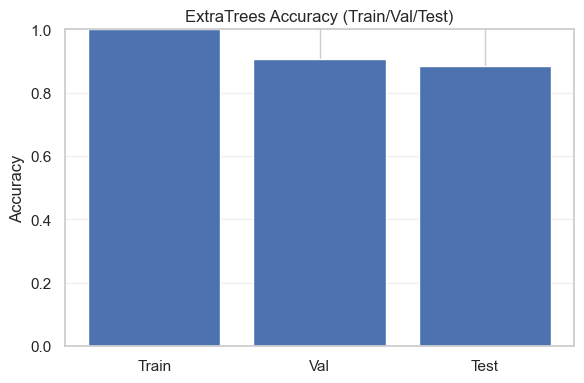

In [45]:
# =============================
# Step 10: Visualization of Training Results
# =============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# -----------------------------
# Safety checks
# -----------------------------
needed = ["X_train_tree", "X_val_tree", "X_test_tree", "y_train", "y_val", "y_test", "best"]
missing = [k for k in needed if k not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}. Run Step 8 then Step 9 first.")

model = best

# Predictions
train_pred = model.predict(X_train_tree)
val_pred = model.predict(X_val_tree)
test_pred = model.predict(X_test_tree)

train_acc = float(accuracy_score(y_train, train_pred))
val_acc = float(accuracy_score(y_val, val_pred))
test_acc = float(accuracy_score(y_test, test_pred))

print(f"Train accuracy: {train_acc:.4f}")
print(f"Val   accuracy: {val_acc:.4f}")
print(f"Test  accuracy: {test_acc:.4f}")

# -----------------------------
# 1) Accuracy bar chart
# -----------------------------
plt.figure(figsize=(6, 4))
plt.bar(["Train", "Val", "Test"], [train_acc, val_acc, test_acc])
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("ExtraTrees Accuracy (Train/Val/Test)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

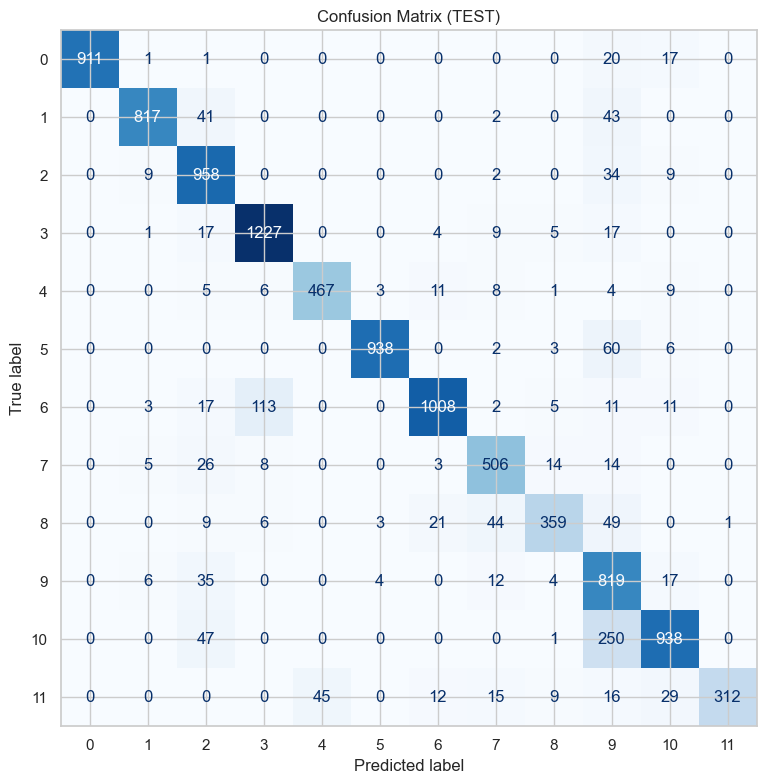

In [46]:
# -----------------------------
# 2) Confusion matrix (TEST)
# -----------------------------
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
ax.set_title("Confusion Matrix (TEST)")
plt.tight_layout()
plt.show()

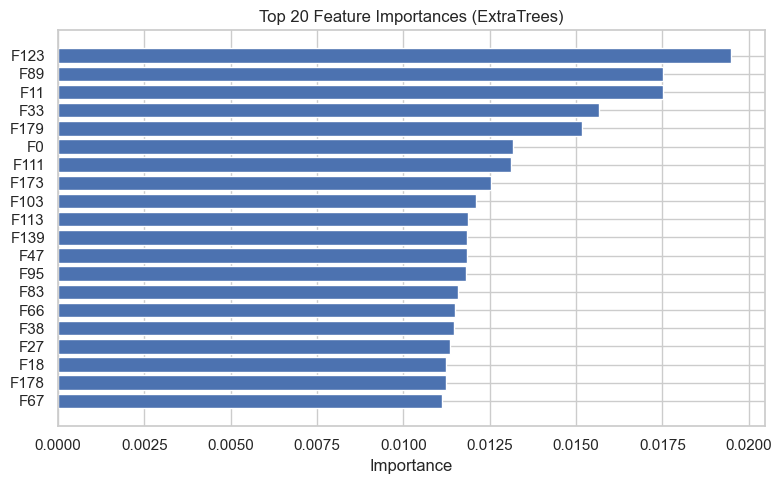

In [47]:
# -----------------------------
# 3) Top feature importances
# -----------------------------
if hasattr(model, "feature_importances_"):
    importances = np.asarray(model.feature_importances_, dtype=float)
    top_k = 20
    idx = np.argsort(importances)[-top_k:][::-1]
    top_vals = importances[idx]

    # Windowed features don't have saved names here; show indices as F0, ...
    labels = [f"F{i}" for i in idx]

    plt.figure(figsize=(8, 5))
    plt.barh(labels[::-1], top_vals[::-1])
    plt.xlabel("Importance")
    plt.title(f"Top {top_k} Feature Importances (ExtraTrees)")
    plt.tight_layout()
    plt.show()
else:
    print("This model does not expose feature importances.")


# Step 11: Robustness Check (No Tuning, Multiple Subject Splits)
This section re-runs the **Train/Val** subject split across several random seeds (while keeping the **Test** split fixed).
It helps you report results as **mean ± std** instead of relying on a single split (which can be optimistic if a seed was auto-picked).

In [48]:
# =============================
# Step 11: Robustness Check (No Tuning)
# =============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

# -----------------------------
# Safety checks
# -----------------------------
required = ["X_raw", "y_raw", "groups_raw", "TEST_RANDOM_STATE", "best"]
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}. Run Step 7 → Step 8 → Step 9 first.")

X_all = np.asarray(X_raw, dtype=np.float32)
y_all = np.asarray(y_raw)
g_all = np.asarray(groups_raw)

# -----------------------------
# Config (keep this laptop-friendly)
# -----------------------------
ROBUST_SEEDS = list(range(0, 11))  # 11 repeats
ROBUST_N_ESTIMATORS = int(min(getattr(best, "n_estimators", 500), 350))
ROBUST_RANDOM_STATE = 42  # model randomness (kept fixed across repeats)

def apply_imputation(X_in: np.ndarray, means: np.ndarray) -> np.ndarray:
    X_out = X_in.astype(np.float32, copy=True)
    bad = ~np.isfinite(X_out)
    if bad.any():
        X_out[bad] = means[np.where(bad)[1]]
    return X_out

def drop_unseen(X_in, y_in, g_in, allowed_labels):
    keep = np.isin(y_in, list(allowed_labels))
    return X_in[keep], y_in[keep], g_in[keep], int((~keep).sum())

# -----------------------------
# Fixed TEST split (subject-based)
# -----------------------------
gss_test = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=int(TEST_RANDOM_STATE))
trainval_idx, test_idx = next(gss_test.split(X_all, y_all, groups=g_all))

X_trainval, y_trainval, g_trainval = X_all[trainval_idx], y_all[trainval_idx], g_all[trainval_idx]
X_test0,    y_test0,    g_test0    = X_all[test_idx],    y_all[test_idx],    g_all[test_idx]

test_subjects = sorted(np.unique(g_test0).tolist())
print("Fixed TEST subjects:", test_subjects)
print("Train+Val subjects:", sorted(np.unique(g_trainval).tolist()))
print("Robust repeats:", len(ROBUST_SEEDS))

# -----------------------------
# Use the selected preset params (but reduce n_estimators for speed)
# -----------------------------
base_params = best.get_params(deep=False)
# Keep only safe/expected params for ExtraTreesClassifier constructor
allowed_keys = {
    "n_estimators","criterion","max_depth","min_samples_split","min_samples_leaf","min_weight_fraction_leaf",
    "max_features","max_leaf_nodes","min_impurity_decrease","bootstrap","oob_score","n_jobs",
    "random_state","verbose","warm_start","class_weight","ccp_alpha","max_samples","monotonic_cst",
}
et_params = {k: v for k, v in base_params.items() if k in allowed_keys}
et_params["n_estimators"] = ROBUST_N_ESTIMATORS
et_params["random_state"] = ROBUST_RANDOM_STATE
et_params["n_jobs"] = -1
et_params["verbose"] = 0
et_params["warm_start"] = False
et_params["oob_score"] = False

print("\nRobust model params (key ones):")
print({k: et_params[k] for k in ["n_estimators","max_depth","max_features","min_samples_leaf","bootstrap","max_samples","class_weight"] if k in et_params})

# -----------------------------
# Run repeats
# -----------------------------
rows = []
for seed in ROBUST_SEEDS:
    # Split trainval into train/val by subject
    gss_val = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=int(seed))
    tr_idx, va_idx = next(gss_val.split(X_trainval, y_trainval, groups=g_trainval))

    X_tr_raw = X_trainval[tr_idx]
    y_tr_raw = y_trainval[tr_idx]
    g_tr = g_trainval[tr_idx]
    X_va_raw = X_trainval[va_idx]
    y_va_raw = y_trainval[va_idx]
    g_va = g_trainval[va_idx]

    # Train-only imputation means
    means = np.nanmean(X_tr_raw, axis=0)
    means = np.nan_to_num(means, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    X_tr = apply_imputation(X_tr_raw, means)
    X_va = apply_imputation(X_va_raw, means)
    X_te = apply_imputation(X_test0,  means)

    # Train-only label encoder, and drop unseen labels from val/test
    le_tmp = LabelEncoder()
    le_tmp.fit(y_tr_raw)
    allowed = set(le_tmp.classes_)
    X_va, y_va2, g_va, dropped_va = drop_unseen(X_va, y_va_raw, g_va, allowed)
    X_te, y_te2, g_te, dropped_te = drop_unseen(X_te, y_test0, g_test0, allowed)

    y_tr = le_tmp.transform(y_tr_raw)
    y_va = le_tmp.transform(y_va2)
    y_te = le_tmp.transform(y_te2)

    model = ExtraTreesClassifier(**et_params)
    model.fit(X_tr, y_tr)

    va_pred = model.predict(X_va)
    te_pred = model.predict(X_te)

    va_acc = float(accuracy_score(y_va, va_pred))
    te_acc = float(accuracy_score(y_te, te_pred))

    rows.append({
        "seed": int(seed),
        "train_subjects": int(len(np.unique(g_tr))),
        "val_subjects": int(len(np.unique(g_va))),
        "val_acc": va_acc,
        "test_acc": te_acc,
        "dropped_val": int(dropped_va),
        "dropped_test": int(dropped_te),
    })

# -----------------------------
# Summary
# -----------------------------
val_accs = np.array([r["val_acc"] for r in rows], dtype=float)
test_accs = np.array([r["test_acc"] for r in rows], dtype=float)
dropped_val = np.array([r["dropped_val"] for r in rows], dtype=int)
dropped_test = np.array([r["dropped_test"] for r in rows], dtype=int)

print("\nRobustness summary (across seeds)")
print("-" * 60)
print(f"VAL  acc: mean={val_accs.mean():.4f}  std={val_accs.std(ddof=1):.4f}  min={val_accs.min():.4f}  max={val_accs.max():.4f}")
print(f"TEST acc: mean={test_accs.mean():.4f}  std={test_accs.std(ddof=1):.4f}  min={test_accs.min():.4f}  max={test_accs.max():.4f}")
print(f"Dropped (VAL) windows due to unseen labels: mean={dropped_val.mean():.1f}")
print(f"Dropped (TEST) windows due to unseen labels: mean={dropped_test.mean():.1f}")

# Display a small table
print("\nPer-seed results:")
for r in rows:
    print(f"seed={r['seed']:>2} | VAL={r['val_acc']:.4f} | TEST={r['test_acc']:.4f} | drop_val={r['dropped_val']:<4} drop_test={r['dropped_test']:<4}")


Fixed TEST subjects: [102, 108]
Train+Val subjects: [101, 103, 104, 105, 106, 107, 109]
Robust repeats: 11

Robust model params (key ones):
{'n_estimators': 350, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': False, 'max_samples': None, 'class_weight': None}

Robustness summary (across seeds)
------------------------------------------------------------
VAL  acc: mean=0.8871  std=0.0477  min=0.7473  max=0.9274
TEST acc: mean=0.8636  std=0.0250  min=0.8003  max=0.8977
Dropped (VAL) windows due to unseen labels: mean=0.0
Dropped (TEST) windows due to unseen labels: mean=0.0

Per-seed results:
seed= 0 | VAL=0.8966 | TEST=0.8567 | drop_val=0    drop_test=0   
seed= 1 | VAL=0.8966 | TEST=0.8567 | drop_val=0    drop_test=0   
seed= 2 | VAL=0.9011 | TEST=0.8803 | drop_val=0    drop_test=0   
seed= 3 | VAL=0.8888 | TEST=0.8733 | drop_val=0    drop_test=0   
seed= 4 | VAL=0.8888 | TEST=0.8733 | drop_val=0    drop_test=0   
seed= 5 | VAL=0.8966 | TEST=0.8567 | drop_v

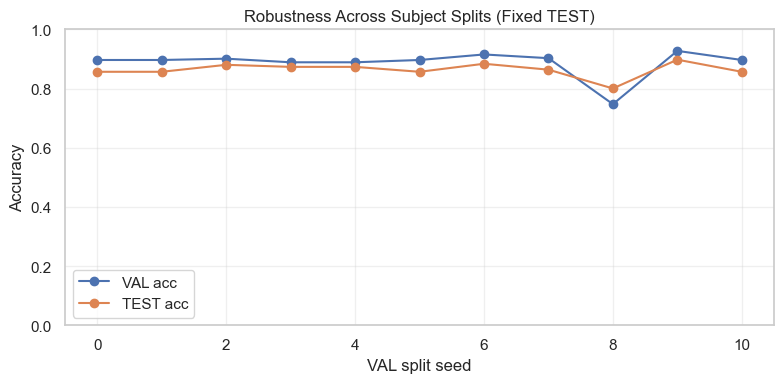

In [51]:
# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot([r["seed"] for r in rows], val_accs, marker="o", label="VAL acc")
plt.plot([r["seed"] for r in rows], test_accs, marker="o", label="TEST acc")
plt.xlabel("VAL split seed")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.title("Robustness Across Subject Splits (Fixed TEST)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Keep results available for later cells
robust_results = rows

# Step 12: Error Analysis 
This section focuses on **TEST-set mistakes**: per-class precision/recall/F1 and the most common confusions (which activities the model mixes up).
It’s lightweight and does not change training (no tuning).

TEST samples: 10477 | classes: 12

Per-class TEST metrics (sorted by F1):


,precision,recall,f1,support
16,0.612565,0.913043,0.733214,897.0
13,0.895262,0.729675,0.804031,492.0
17,0.905405,0.758900,0.825704,1236.0
24,0.996805,0.712329,0.830892,438.0
12,0.840532,0.878472,0.859083,576.0
3,0.828720,0.946640,0.883764,1012.0
7,0.951841,0.861538,0.904441,1170.0
5,0.912109,0.908560,0.910331,514.0
4,0.902206,0.958594,0.929545,1280.0
2,0.970309,0.904762,0.936390,903.0


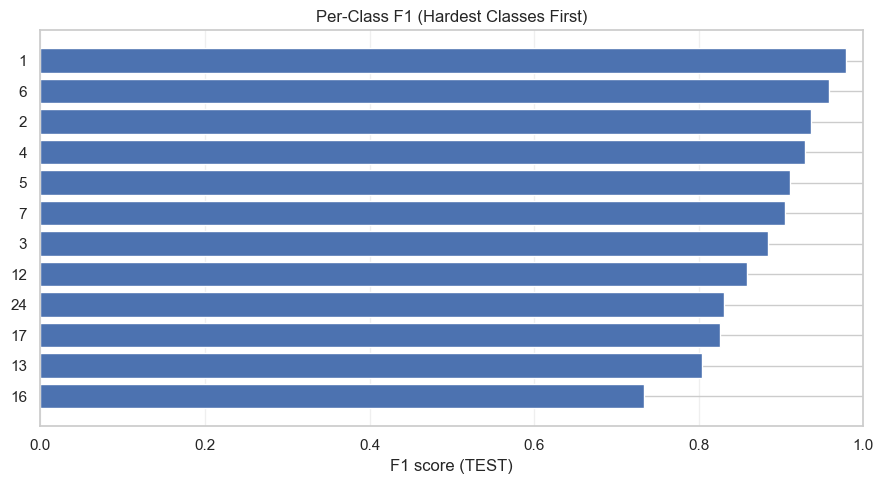


Most common confusions (TEST) [true → predicted]:
  17 → 16 : 250  (20.2% of true 17)
  7 → 4 : 113  (9.7% of true 7)
  6 → 16 : 60  (5.9% of true 6)
  13 → 16 : 49  (10.0% of true 13)
  17 → 3 : 47  (3.8% of true 17)
  24 → 5 : 45  (10.3% of true 24)
  13 → 12 : 44  (8.9% of true 13)
  2 → 16 : 43  (4.8% of true 2)
  2 → 3 : 41  (4.5% of true 2)
  16 → 3 : 35  (3.9% of true 16)


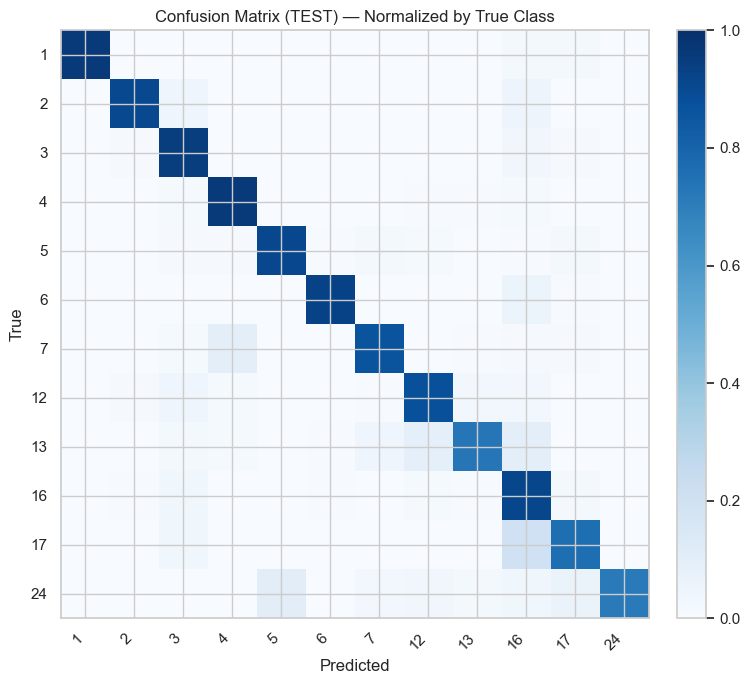

In [52]:
# =============================
# Step 12: Error Analysis (TEST)
# =============================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Safety checks
# -----------------------------
needed = ["best", "X_test_tree", "y_test"]
missing = [k for k in needed if k not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}. Run Step 8 → Step 9 → Step 10 first.")

model = best
y_pred = model.predict(X_test_tree)
y_true = np.asarray(y_test)

n_classes = int(len(np.unique(y_true)))
print("TEST samples:", len(y_true), "| classes:", n_classes)

# Optional: map encoded labels back to original activity IDs (if LabelEncoder exists)
display_labels = None
if "le" in globals():
    try:
        # le.classes_ contains original activity IDs (e.g., 1,2,3,...)
        display_labels = [str(c) for c in list(le.classes_)]
    except Exception:
        display_labels = None

# -----------------------------
# 1) Per-class metrics table
# -----------------------------
rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
df_rep = (
    pd.DataFrame(rep).T
    .rename(columns={"f1-score": "f1"})
)

# Keep only the per-class rows (exclude averages/accuracy)
df_classes = df_rep.loc[[idx for idx in df_rep.index if idx not in ("accuracy","macro avg","weighted avg")]].copy()
df_classes.index = df_classes.index.astype(str)

# If we can label with original activity IDs, replace index with those labels
if display_labels is not None and len(display_labels) == len(df_classes.index):
    df_classes.index = display_labels

df_classes = df_classes[["precision", "recall", "f1", "support"]].sort_values("f1", ascending=True)

print("\nPer-class TEST metrics (sorted by F1):")
display(df_classes)

# Plot: F1 per class (hardest on top)
plt.figure(figsize=(9, 5))
plt.barh(df_classes.index, df_classes["f1"].values)
plt.xlabel("F1 score (TEST)")
plt.title("Per-Class F1 (Hardest Classes First)")
plt.xlim(0, 1.0)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Top confusions from confusion matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)

top_k = min(10, cm_off.size)
flat_idx = np.argsort(cm_off.ravel())[::-1]
pairs = []
for idx in flat_idx:
    count = int(cm_off.ravel()[idx])
    if count <= 0:
        break
    i, j = np.unravel_index(idx, cm_off.shape)
    pairs.append((i, j, count))
    if len(pairs) >= top_k:
        break

def _lbl(i: int) -> str:
    if display_labels is None:
        return str(i)
    if 0 <= i < len(display_labels):
        return str(display_labels[i])
    return str(i)

print("\nMost common confusions (TEST) [true → predicted]:")
if not pairs:
    print("No off-diagonal confusions found (unlikely).")
else:
    for i, j, count in pairs:
        row_sum = int(cm[i, :].sum())
        pct = (count / row_sum * 100.0) if row_sum > 0 else 0.0
        print(f"  {_lbl(i)} → {_lbl(j)} : {count}  ({pct:.1f}% of true {_lbl(i)})")

# -----------------------------
# 3) Confusion matrix heatmap (normalized by true class)
# -----------------------------
cm_norm = cm.astype(float)
row_sums = cm_norm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_norm, row_sums, out=np.zeros_like(cm_norm), where=row_sums != 0)

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)
ax.set_title("Confusion Matrix (TEST) — Normalized by True Class")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ticks = np.arange(cm.shape[0])
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels([_lbl(i) for i in ticks], rotation=45, ha="right")
ax.set_yticklabels([_lbl(i) for i in ticks])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# Step 13: Baseline Model Comparison
This section compares a few **fast baseline classifiers** against your current ExtraTrees model on the same Train/Val/Test splits.
It helps you justify why ExtraTrees is a strong choice, without doing any hyperparameter tuning.

In [55]:
# =============================
# Step 13: Baseline Model Comparison (No Tuning)
# =============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# Safety checks
# -----------------------------
needed = ["X_train", "X_val", "X_test", "X_train_tree", "X_val_tree", "X_test_tree", "y_train", "y_val", "y_test", "best"]
missing = [k for k in needed if k not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}. Run Step 8 → Step 9 first.")

def _score(y_true, y_pred):
    return {
        "acc": float(accuracy_score(y_true, y_pred)),
        "f1_weighted": float(f1_score(y_true, y_pred, average="weighted", zero_division=0)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
    }

results = []

# -----------------------------
# 1) Fast linear baseline (scaled features)
# -----------------------------
t0 = perf_counter()
sgd = SGDClassifier(
    loss="log_loss", penalty="l2", alpha=1e-4,
    max_iter=3000, tol=1e-3, random_state=42, n_jobs=-1,
 )
sgd.fit(X_train, y_train)
val_pred = sgd.predict(X_val)
test_pred = sgd.predict(X_test)
results.append({"model": "SGD (logreg)", "secs": perf_counter()-t0, **{f"val_{k}": v for k,v in _score(y_val, val_pred).items()}, **{f"test_{k}": v for k,v in _score(y_test, test_pred).items()}})

# -----------------------------
# 2) Ridge classifier baseline (scaled features)
# -----------------------------
t0 = perf_counter()
ridge = RidgeClassifier(random_state=42)
ridge.fit(X_train, y_train)
val_pred = ridge.predict(X_val)
test_pred = ridge.predict(X_test)
results.append({"model": "RidgeClassifier", "secs": perf_counter()-t0, **{f"val_{k}": v for k,v in _score(y_val, val_pred).items()}, **{f"test_{k}": v for k,v in _score(y_test, test_pred).items()}})

# -----------------------------
# 3) Naive Bayes baseline (scaled features)
# -----------------------------
t0 = perf_counter()
gnb = GaussianNB()
gnb.fit(X_train, y_train)
val_pred = gnb.predict(X_val)
test_pred = gnb.predict(X_test)
results.append({"model": "GaussianNB", "secs": perf_counter()-t0, **{f"val_{k}": v for k,v in _score(y_val, val_pred).items()}, **{f"test_{k}": v for k,v in _score(y_test, test_pred).items()}})

# -----------------------------
# 4) RandomForest small baseline (tree features, unscaled)
# -----------------------------
t0 = perf_counter()
rf = RandomForestClassifier(
    n_estimators=250, max_depth=30, max_features="sqrt",
    min_samples_leaf=2, n_jobs=-1, random_state=42,
)
rf.fit(X_train_tree, y_train)
val_pred = rf.predict(X_val_tree)
test_pred = rf.predict(X_test_tree)
results.append({"model": "RandomForest (small)", "secs": perf_counter()-t0, **{f"val_{k}": v for k,v in _score(y_val, val_pred).items()}, **{f"test_{k}": v for k,v in _score(y_test, test_pred).items()}})

# -----------------------------
# 5) Your final model (ExtraTrees best)
# -----------------------------
t0 = perf_counter()
et = best
val_pred = et.predict(X_val_tree)
test_pred = et.predict(X_test_tree)
results.append({"model": "ExtraTrees (final)", "secs": perf_counter()-t0, **{f"val_{k}": v for k,v in _score(y_val, val_pred).items()}, **{f"test_{k}": v for k,v in _score(y_test, test_pred).items()}})

df_cmp = pd.DataFrame(results)
df_cmp = df_cmp.sort_values("test_acc", ascending=False).reset_index(drop=True)
print("Baseline comparison (higher is better):")
display(df_cmp[["model","secs","val_acc","val_f1_weighted","val_f1_macro","test_acc","test_f1_weighted","test_f1_macro"]])

Baseline comparison (higher is better):


,model,secs,val_acc,val_f1_weighted,val_f1_macro,test_acc,test_f1_weighted,test_f1_macro
0,ExtraTrees (final),0.281732,0.905899,0.904571,0.828934,0.883841,0.886303,0.879588
1,RandomForest (small),7.342854,0.902353,0.901562,0.824509,0.807388,0.814694,0.818456
2,RidgeClassifier,0.022952,0.867597,0.866819,0.797872,0.728262,0.716510,0.720772
3,GaussianNB,0.059207,0.817945,0.820378,0.745637,0.722344,0.727970,0.716070
4,SGD (logreg),4.115506,0.873153,0.870102,0.800626,0.650950,0.642479,0.665716


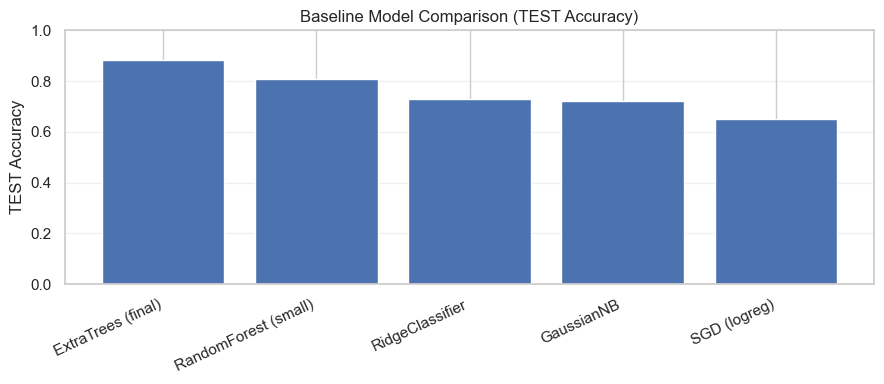

In [56]:
# Plot: TEST accuracy
plt.figure(figsize=(9, 4))
plt.bar(df_cmp["model"], df_cmp["test_acc"].values)
plt.ylabel("TEST Accuracy")
plt.ylim(0, 1.0)
plt.title("Baseline Model Comparison (TEST Accuracy)")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Step 14: Final Summary

This section prints a compact summary of your final setup and results (best model, key settings, VAL/TEST metrics, robustness summary, and the hardest classes).

In [58]:
# =============================
# Step 14: Final Summary (Ready-to-Submit)
# =============================

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# -----------------------------
# Safety checks
# -----------------------------
needed_any = ["best", "X_val_tree", "X_test_tree", "y_val", "y_test"]
missing = [k for k in needed_any if k not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}. Run Step 8 → Step 9 → Step 10 first.")

model = best
preset_name = globals().get("best_name", "(unknown)")

# Recompute VAL/TEST (fast)
val_pred = model.predict(X_val_tree)
test_pred = model.predict(X_test_tree)
val_acc = float(accuracy_score(y_val, val_pred))
test_acc = float(accuracy_score(y_test, test_pred))

# Optional train accuracy (can be slower; keep default off)
INCLUDE_TRAIN_ACC = False
train_acc = None
if INCLUDE_TRAIN_ACC and "X_train_tree" in globals() and "y_train" in globals():
    train_pred = model.predict(X_train_tree)
    train_acc = float(accuracy_score(y_train, train_pred))

# Robustness summary (if Step 11 ran)
robust_line = "Robustness: (run Step 11 to get mean±std)"
if "robust_results" in globals() and isinstance(robust_results, list) and len(robust_results) > 0:
    va = np.array([r.get("val_acc", np.nan) for r in robust_results], dtype=float)
    te = np.array([r.get("test_acc", np.nan) for r in robust_results], dtype=float)
    robust_line = (
        f"Robustness (n={len(robust_results)}): "
        f"VAL {np.nanmean(va):.4f}±{np.nanstd(va, ddof=1) if len(va)>1 else 0.0:.4f}, "
        f"TEST {np.nanmean(te):.4f}±{np.nanstd(te, ddof=1) if len(te)>1 else 0.0:.4f}"
    )

# Baseline ranking (if Step 13 ran and df_cmp exists)
baseline_top = None
if "df_cmp" in globals() and isinstance(df_cmp, pd.DataFrame) and ("test_acc" in df_cmp.columns):
    baseline_top = df_cmp[["model","test_acc","test_f1_weighted","test_f1_macro"]].head(3).copy()

# Hardest classes (if Step 12 ran and df_classes exists)
hardest = None
if "df_classes" in globals() and isinstance(df_classes, pd.DataFrame) and ("f1" in df_classes.columns):
    hardest = df_classes[["precision","recall","f1","support"]].head(5).copy()

print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)
print("Model      : ExtraTreesClassifier")
print("Preset     :", preset_name)
print("FeatureMode:", globals().get("FEATURE_MODE", "(unknown)"))
print("Window     : WIN_SIZE=", globals().get("WIN_SIZE", "?"), ", HOP_SIZE=", globals().get("HOP_SIZE", "?"), ", LABEL_STABILITY=", globals().get("LABEL_STABILITY", "?"), sep="")
print("Split      : TEST_RANDOM_STATE=", globals().get("TEST_RANDOM_STATE", "?"), ", VAL seed=", globals().get("val_seed", globals().get("DEFAULT_VAL_RANDOM_STATE", "?")), ", AUTO_PICK_VAL_SPLIT=", globals().get("AUTO_PICK_VAL_SPLIT", "?"), sep="")
print()


FINAL SUMMARY
Model      : ExtraTreesClassifier
Preset     : reg_depth40_leaf2
FeatureMode: rich
Window     : WIN_SIZE=100, HOP_SIZE=50, LABEL_STABILITY=0.8
Split      : TEST_RANDOM_STATE=42, VAL seed=2, AUTO_PICK_VAL_SPLIT=True



In [59]:
if train_acc is not None:
    print(f"Train acc  : {train_acc:.4f}")
print(f"Val acc    : {val_acc:.4f}")
print(f"Test acc   : {test_acc:.4f}")
print(robust_line)

Val acc    : 0.9059
Test acc   : 0.8838
Robustness (n=11): VAL 0.8871±0.0477, TEST 0.8636±0.0250


In [60]:
if baseline_top is not None:
    print("\nTop baselines by TEST accuracy:")
    display(baseline_top)

if hardest is not None:
    print("\nHardest classes on TEST (lowest F1):")
    display(hardest)



Top baselines by TEST accuracy:


,model,test_acc,test_f1_weighted,test_f1_macro
0,ExtraTrees (final),0.883841,0.886303,0.879588
1,RandomForest (small),0.807388,0.814694,0.818456
2,RidgeClassifier,0.728262,0.716510,0.720772



Hardest classes on TEST (lowest F1):


,precision,recall,f1,support
16,0.612565,0.913043,0.733214,897.0
13,0.895262,0.729675,0.804031,492.0
17,0.905405,0.758900,0.825704,1236.0
24,0.996805,0.712329,0.830892,438.0
12,0.840532,0.878472,0.859083,576.0


In [61]:
print("\nReady-to-write report notes:")
print("- No hyperparameter tuning (no CV search); fixed presets only.")
print("- Subject-independent split via GroupShuffleSplit.")
print("- VAL may be optimistic if AUTO_PICK_VAL_SPLIT=True; robustness summary is preferred.")


Ready-to-write report notes:
- No hyperparameter tuning (no CV search); fixed presets only.
- Subject-independent split via GroupShuffleSplit.
- VAL may be optimistic if AUTO_PICK_VAL_SPLIT=True; robustness summary is preferred.


# Step 15: Final Report 
This section generates a short, ready-to-submit report write-up (aim, method, and results).
Optional: it can also save the report as a `.md` file.

In [62]:
# =============================
# Step 15: Final Report 
# =============================

import os
from datetime import datetime
import numpy as np

# Optional: save report to disk
SAVE_REPORT = True
REPORT_PATH = "data/final_report.md"

# -----------------------------
# Safety checks
# -----------------------------
if "best" not in globals():
    raise RuntimeError("Missing `best`. Run Step 9 (ExtraTrees) first.")

preset_name = globals().get("best_name", "ExtraTrees")
feature_mode = globals().get("FEATURE_MODE", "unknown")
win_size = globals().get("WIN_SIZE", "?")
hop_size = globals().get("HOP_SIZE", "?")
label_stability = globals().get("LABEL_STABILITY", "?")
test_rs = globals().get("TEST_RANDOM_STATE", "?")
val_seed_used = globals().get("val_seed", globals().get("DEFAULT_VAL_RANDOM_STATE", "?"))
auto_pick = globals().get("AUTO_PICK_VAL_SPLIT", "?")

# Metrics (use Step 14 computed values if available; else recompute quickly)
val_acc = globals().get("val_acc")
test_acc = globals().get("test_acc")
if val_acc is None or test_acc is None:
    if not all(k in globals() for k in ("X_val_tree", "X_test_tree", "y_val", "y_test")):
        raise RuntimeError("Missing split arrays. Run Step 8 → Step 9 → Step 10 first.")
    from sklearn.metrics import accuracy_score
    val_pred = best.predict(X_val_tree)
    test_pred = best.predict(X_test_tree)
    val_acc = float(accuracy_score(y_val, val_pred))
    test_acc = float(accuracy_score(y_test, test_pred))

# Robustness summary if Step 11 ran
robust_text = "Not computed (run Step 11)."
if "robust_results" in globals() and isinstance(robust_results, list) and len(robust_results) > 0:
    va = np.array([r.get("val_acc", np.nan) for r in robust_results], dtype=float)
    te = np.array([r.get("test_acc", np.nan) for r in robust_results], dtype=float)
    robust_text = (
        f"VAL {np.nanmean(va):.4f}±{np.nanstd(va, ddof=1) if len(va)>1 else 0.0:.4f}, "
        f"TEST {np.nanmean(te):.4f}±{np.nanstd(te, ddof=1) if len(te)>1 else 0.0:.4f} (n={len(robust_results)})"
    )

# Baseline snapshot if Step 13 ran
baseline_lines = []
if "df_cmp" in globals() and hasattr(df_cmp, "sort_values"):
    try:
        top = df_cmp.sort_values("test_acc", ascending=False).head(3)[["model", "test_acc"]].values.tolist()
        baseline_lines = [f"- {m}: {a:.4f}" for m, a in top]
    except Exception:
        baseline_lines = []

ts = datetime.now().strftime("%Y-%m-%d %H:%M")
lines = []
lines.append("# Final Project Report (PAMAP2 Human Activity Recognition)")
lines.append("")
lines.append(f"Generated: {ts}")
lines.append("")
lines.append("## Objective")
lines.append("Build a subject-independent human activity recognition model on PAMAP2 sensor data using window-based feature extraction and strict subject-based splitting (no subject leakage).")
lines.append("")
lines.append("## Method")
lines.append("- Data: PAMAP2 subject*.dat; transient activity (0) removed; heart rate forward-filled per subject.")
lines.append(f"- Features: window statistics ({feature_mode} mode) with WIN_SIZE={win_size}, HOP_SIZE={hop_size}, LABEL_STABILITY={label_stability}.")
lines.append(f"- Split: GroupShuffleSplit; TEST_RANDOM_STATE={test_rs}; VAL seed={val_seed_used}; AUTO_PICK_VAL_SPLIT={auto_pick}.")
lines.append(f"- Model: ExtraTreesClassifier (preset: {preset_name}); no CV hyperparameter tuning (fixed presets only).")
lines.append("")
lines.append("## Results")
lines.append(f"- Validation accuracy: {float(val_acc):.4f}")
lines.append(f"- Test accuracy: {float(test_acc):.4f}")
lines.append(f"- Robustness across multiple VAL splits: {robust_text}")
lines.append("")
lines.append("## Baselines (Step 13)")
if baseline_lines:
    lines.extend(baseline_lines)
else:
    lines.append("Baselines were evaluated in Step 13 (run it to include top-3 here).")
lines.append("")
lines.append("## Notes / Limitations")
lines.append("- ExtraTrees can reach very high training accuracy; generalization is assessed using validation and a fixed test split.")
lines.append("- If AUTO_PICK_VAL_SPLIT=True, the single VAL number can be optimistic; the Step 11 robustness summary is more reliable.")
report_md = "\n".join(lines)

# Display in notebook
try:
    from IPython.display import Markdown, display
    display(Markdown(report_md))
except Exception:
    print(report_md)

# Optional save
if SAVE_REPORT:
    os.makedirs(os.path.dirname(REPORT_PATH), exist_ok=True)
    with open(REPORT_PATH, "w", encoding="utf-8") as f:
        f.write(report_md)
    print("\nSaved report to:", REPORT_PATH)

# Final Project Report (PAMAP2 Human Activity Recognition)

Generated: 2025-12-25 16:43

## Objective
Build a subject-independent human activity recognition model on PAMAP2 sensor data using window-based feature extraction and strict subject-based splitting (no subject leakage).

## Method
- Data: PAMAP2 subject*.dat; transient activity (0) removed; heart rate forward-filled per subject.
- Features: window statistics (rich mode) with WIN_SIZE=100, HOP_SIZE=50, LABEL_STABILITY=0.8.
- Split: GroupShuffleSplit; TEST_RANDOM_STATE=42; VAL seed=2; AUTO_PICK_VAL_SPLIT=True.
- Model: ExtraTreesClassifier (preset: reg_depth40_leaf2); no CV hyperparameter tuning (fixed presets only).

## Results
- Validation accuracy: 0.9059
- Test accuracy: 0.8838
- Robustness across multiple VAL splits: VAL 0.8871±0.0477, TEST 0.8636±0.0250 (n=11)

## Baselines (Step 13)
- ExtraTrees (final): 0.8838
- RandomForest (small): 0.8074
- RidgeClassifier: 0.7283

## Notes / Limitations
- ExtraTrees can reach very high training accuracy; generalization is assessed using validation and a fixed test split.
- If AUTO_PICK_VAL_SPLIT=True, the single VAL number can be optimistic; the Step 11 robustness summary is more reliable.


Saved report to: data/final_report.md
